<h3><center><font color = "blue">스마트 홈 관련 코스피 상장사 중 테마주 정보를 중심으로 'Efficient Frontier' 제시</font></h3> 
<h4><p style='text-align: right;'><font color = "blue"></font></p></h4>  

_**INTRODUCTION**_
    
    과거 지능형 주택으로 불리던 1990년 경의 스마트 홈 시장은, MicroSoft에 의해, 국내 IT 유수기업 간 모바일 익스플로러(MME) 협력개발이 착수된  2000년 6월 경을 촉매로하여, 스마트홈 시장은 꾸준한 발전 가도 위에 있다. 
    최근 3년 간은 정부 역시 해당시장에 관심도를 높이며, 스마트홈을 포함한 AI 관련 시장에 4.7조원 투자할 만큼, 20년 간 위 시장은 제법 안정적인 시장상황을 구축해 왔으며, 지난 발전 동향을 미루어보아, 향 후 미래 역시 안정적인 시장일 것임을 기대할 수 있다.

    그러나, 익히 알 듯, 경제는 급격히 변화하며, 경제상황은 예측할 수 없는 영역이기에, 이를 대비할 대책을 마련하기 위한 취지로, 본 프로젝트는 시작되었다. 

    본 프로젝트에서는 과거 유수 기업 사이의 주식시장 정보를 활용하여 효율적 투자를 이루기 위한 방책을 제시하고자 한다. 과거 시장의 변화를 통해 어떤한 변화가 잇따라 왔는지 를 분석하고, 미래 시장에 대한 '기대'와 '실제'가 얼마나 일치될 수 있는지를 예측해 보려고한다.

**In 1990’s smart home, known back then as intelligent housing system, market was pioneered by Microsoft. Due to this, in June 2000 cooperation for development was made between Internet Explorer Mobile (MME) and Korea Information Technology (IT) companies, which triggered in steady development of smart home market.  
In the past three years, government has invested 4.7 trillion won (KRW) in the industry of smart home including Artificial Intelligence (AI). This could be interpreted as this industry has established stable market since 2000s as well as it could be estimated that it is worth investing for the future of how the market has grown. 
Despite economics are unpredictable and fluctuating dramatically, this project has been started in order to prepare for a resolution.
This project will be analysed based on the Korea Composite Stock Price Index (KOSPI) data, which has been collected for 21 years in the field of smart home industry. Among those data, ten companies have been chosen in order to be analysed with efficient frontier. It will also analyse when market changed what chain reaction has occurred to the industry. As well as examining how similar forecasted values are compared with real values.**


In [1]:
# File Check
import os
import glob

import requests
import pandas as pd
import numpy as np
import datetime as dt
import time

# !pip install pykrx
from pykrx import stock

from scipy import stats
from functools import reduce
from datetime import date

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import seaborn as sns 

import statsmodels.api as sm

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#  iframe renderer that stores each figure as a separate HTML file in a directory next to the notebook and then inserts an iframe in the notebook that references the HTML file.
import plotly.io as pio
pio.renderers.default = 'iframe'

# Error fix
import warnings
warnings.simplefilter("ignore")

plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

# Modeling
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.ensemble import IsolationForest

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna

In [11]:
stock_info = ['에스원 012750', 
              'HDC아이콘트롤스 039570',
              '경동나비엔 009450', 
              '현대리바트 079430',
              '엘지전자 066570',
              '삼성전자 005930',
              '지에스건설 006360',
              '에스케이텔레콤 017670',
              '케이티 030200',
              '엘지유플러스 032640']

stock_name_list = []
stock_code_list = []

for i in range(len(stock_info)):
    sl = stock_info[i].split(' ')
    stock_name_list.append(sl[0])
    stock_code_list.append(sl[1])
# stock_name_list , stock_code_list    

In [32]:
def cr_df(company, number = 2):
    # list_1
    df_save = []
    recent_date = ['2021-01-31']
    df_save.append(pd.DataFrame(recent_date, columns=['date']))
    # list_2
    params = []
    for i in range(number):
        params.append({
            'access_key': '21ab33d30ae3b6ebcb1e5727a699f17d',
            'date_to' : df_save[i]['date'].tail(1)
        })
        api_result = requests.get(f'https://api.marketstack.com/v1/tickers/{company}/eod', params[i])
        api_response = api_result.json()
        df_save.append(pd.DataFrame(api_response['data']['eod']))
    return pd.concat(df_save).drop(index=0).reset_index().drop_duplicates("date", keep="first")

# 해당 주식정보 불러오기
def c_str(tx):
    return tx + '.XKRX`'
symbols = pd.Series(stock_code_list).to_frame()[0].apply(c_str)

Sk_by_comp = []
sym_list = symbols.tolist()
for stock in range(10):
    Sk_by_comp.append(cr_df(sym_list[stock], number = 53))
    Sk_by_comp[stock]['symbol'] = np.repeat(stock_name_list[stock], len(Sk_by_comp[stock]), axis=0)

In [12]:
# 파일 csv변환 및 변환된 파일 불러오기
Sk_by_comp_n = []
Sk_eps_n = []

for i in range(10):
    sk_name = stock_name_list[i]
#     Sk_by_comp[i].to_csv(f'Data/skinfo_{sk_name}.csv',index=False)
    
    # api 통해 호출하여 생성한 종목별 주식성보
    Sk_by_comp_n.append(pd.read_csv(f'Data/skinfo_{sk_name}.csv'))
    # ets 정보
    Sk_eps_n.append(pd.read_csv(f'Data_2/EPS_{sk_name}.csv', encoding='cp949'))
    Sk_eps_n[i]['symbol'] = np.repeat(sk_name, len(Sk_eps_n[i]))     

# 파일 저장상태 확인
def get_file_list_title(sk_name, forder='Data', info='skinfo'):
    file_list = []
    for root, dirs, files in os.walk(f"{forder}/"):
        for filename in files:
            if filename.startswith(f'{info}_{sk_name}'):
                file_list.append(filename)
    return sorted(file_list)

# 파일체크
# for i in range(10):
#     print(get_file_list_title(stock_name_list[i]))
#     print(get_file_list_title(stock_name_list[i], "Data_2", "EPS"))

# 각 회사의 마지막 주식 날짜정보 확인
# print('Company    ','   index &last_date')
# print(65*'-')
# for i in range(len(stock_info)):
#     print(Sk_by_comp_n[i]['symbol'][0], Sk_by_comp_n[i].tail(1)['date']) 
#     print(Sk_eps_n[i]['symbol'][0], 'EPS' ,Sk_eps_n[i].tail(1)['일자'])     

In [13]:
# 년 월 일 데이터만 선별하여 Date time 화 하고 이를 시계열 분석을 위해 Index로 설정
for j in range(10) :
    Sk_by_comp_n_each = Sk_by_comp_n[j].copy()
    Sk_by_comp_n_each_ = Sk_eps_n[j].copy()
    
    Date_list = []
    Date_list_ = []
    
    for i in range(Sk_by_comp_n_each.shape[0]):
        semi_r = Sk_by_comp_n_each.iloc[:,1][i].split('T')
        semi_r_n = dt.datetime.strptime(semi_r[0], '%Y-%m-%d').date()
        Date_list.append(semi_r_n)
        
#     print(Sk_by_comp_n_each['symbol'][0], 'Number of rows and columns')        
#     print(Sk_by_comp_n_each.shape)
    
    Sk_by_comp_n_each['date'] = Date_list
    Sk_by_comp_n_each.set_index('date', inplace=True)
    Sk_by_comp_n[j] = Sk_by_comp_n_each
    
    for i_2 in range(Sk_by_comp_n_each_.shape[0]):
        semi_r_ = Sk_by_comp_n_each_.iloc[:,0][i_2].replace("/","-")
        semi_r_n_ = dt.datetime.strptime(semi_r_, '%Y-%m-%d').date()
        Date_list_.append(semi_r_n_)
        
#     print(Sk_by_comp_n_each_['symbol'][0], 'EPS', 'Number of rows and columns')        
#     print(Sk_by_comp_n_each_.shape)
    
    Sk_by_comp_n_each_['일자'] = Date_list_
    Sk_by_comp_n_each_.set_index('일자', inplace=True)
    Sk_eps_n[j] = Sk_by_comp_n_each_

---

https://docs.google.com/spreadsheets/d/1C0dbTXVvx7ztGubhyfLXi4nHCh6tPMbX0RHqNgMwC_A/edit#gid=745316568

**Intention of this project is that diversified investment is crucial for investors when investing in the stock market. Our team has read more than 3000 articles in order to find the market trend of smart home as well as comparing with the stock data as one of the steps for applying diversified investment.**

<center><img src="./Image/Techinical_background.PNG" width=1000 height=300></center> 

In [134]:
df_per_pbr = []
for i in range(len(Sk_eps_n)):
    eps_df = Sk_eps_n[i].copy()
    stock_df = Sk_by_comp_n[i].copy()
    
    eps_df.index.names = ['date']
    result = stock_df.merge(eps_df[['EPS', 'BPS', '주당배당금', '배당수익률']], on='date', how='left')

    df_per_pbr.append(result)    

In [135]:
def year_month(nth): 
    spl_date = df_per_pbr[nth].copy()
    y = []
    m = []
    for i in range(len(spl_date)):
        y.append(spl_date.index[i].year)
        m.append(spl_date.index[i].month)
        
    spl_date['year'] = y    
    spl_date['month'] = m    
    df_per_pbr[nth] = spl_date.copy()

for n in range(10):
    year_month(n)

dividend_list = []
for i in range(10):
    series = df_per_pbr[i].groupby('year')['주당배당금'].mean().round(1)
    df = pd.DataFrame(series)
    df = df[df.주당배당금 > 100]
    df['symbol'] = np.repeat(stock_name_list[i], len(df), axis=0)
    dividend_list.append(df)
    
Collected = pd.concat(dividend_list)
Top_Dividend = Collected.groupby('year')['주당배당금'].max().round(1)
Top_Dividend = pd.DataFrame(Top_Dividend)

symbol_list = []
for i in range(len(Top_Dividend)):
    symbol_list.append(Collected['symbol'].iloc[np.where(Collected['주당배당금'] == Top_Dividend.iloc[i,:][0])[0][0]])
Top_Dividend['symbol'] = symbol_list
Top_Dividend.tail(10)

fig = go.Figure()
y = Top_Dividend['주당배당금']
x = Top_Dividend.index
def SetColor(y):
    if y < Top_Dividend['주당배당금'].describe()['25%']: 
        return "lightsteelblue"
    elif y >= Top_Dividend['주당배당금'].describe()['25%'] and y < Top_Dividend['주당배당금'].describe()['50%']:
        return "lightblue"
    elif y >= Top_Dividend['주당배당금'].describe()['50%'] and y < Top_Dividend['주당배당금'].describe()['75%']:
        return "palevioletred"
    else:
        return "crimson"
fig.add_trace(go.Bar(x=x, y=y,
                     marker=dict(color = list(map(SetColor, y)))))
fig.add_vline(x=2014, line_width=1.5, line_dash="dot", line_color="dimgray")

for i in range(len(Top_Dividend)):
    if Top_Dividend.index[i] >= 2014:
        fig.add_annotation(x=Top_Dividend.index[i] -0.01, y=(Top_Dividend['주당배당금'].iloc[i] + 5000),
                           text=Top_Dividend['symbol'].iloc[i],
                           font_size=10,
                           textangle=50,
                           showarrow=True,
                           arrowcolor='red',
                           arrowsize = 2,
                           arrowhead=4,
                           arrowwidth=1.2,
                           ay=30)

fig.add_annotation(x=2014, y=30000,
                   text='Since 2014, companies that has recorded the highest mean dividends per share outran overall 25th percentile.',
                   font=dict(
                       family="Courier New, monospace",
                       size=12,
                       color="gray"),
                   arrowwidth=2,
                   align="center",
                   ax=-320,
                   ay=-80,
                   bordercolor="#c7c7c7",
                   borderwidth=2,
                   borderpad=4,
                   bgcolor="white",
                   opacity=0.8)


fig.update_layout(
    width=1800,
    height=450,
    showlegend=True,
    plot_bgcolor='lightcyan',
    title_text='Annual Comparison of companies with the Highest Dividends per Share ')
fig.update_yaxes(title_text='Annual Dividends per Share')
fig.update_layout(showlegend=False)
fig.show()

**per_check**

In [136]:
# calculate per and 
per_trend = []
for nth in range(len(df_per_pbr)): 
    df_n = df_per_pbr[nth].sort_values(by='date', ascending=True)
    df_n['per'] = df_n['EPS'] / df_n['close']
    df_n['year'] = np.nan
    for row in range(len(df_n)):
        df_n['year'][row] = df_n.index[row].year
    per_trend.append(df_n)     

In [137]:
st_date = np.where(per_trend[0].index == pd.to_datetime('2010-01-04'))[0][0]
lt_date = len(per_trend[0])
new_date_index = per_trend[0].index[st_date:lt_date]

In [138]:
per_trend_df = pd.DataFrame(range(len(new_date_index)), columns=['col'], index=new_date_index)

In [139]:
result = []
for list_num in range(len(per_trend)):
    result.append(pd.merge(per_trend_df, per_trend[list_num]['per'], how='left', left_index=True, right_index=True))
    
per_trend_df = reduce(lambda left,right: pd.merge(left,right,on='date'), result)
per_trend_df = per_trend_df.drop(['col_x', 'col_y'], axis = 1)
per_trend_df.columns = stock_name_list

In [140]:
for col in range(len(per_trend_df.columns)):
    name = str(stock_name_list[col] + 'r')
    per_trend_df[name] = per_trend_df.iloc[:,col].rolling(window=255, center=True, min_periods=220).mean()

In [141]:
# make fake data
arr0 = np.arange(-0.08,1.4,1.4)
arr1 = np.arange(1.4, 0, -0.015)
arr2 = np.arange(0, -0.08, -(0.08)/(len(per_trend_df) - (len(arr1) + len(arr0))))
arr = np.concatenate((arr0, arr1, arr2))
per_trend_df['fake_data'] = arr

In [142]:
df = per_trend_df.iloc[:,10:]
df['Date'] = per_trend_df.index
y_list = df.iloc[:,0:11].columns.tolist()
fig = px.line(df, x="Date", y=y_list,
              color_discrete_map={
                  y_list[0]: "lightgray",
                  y_list[1]: "lightgray",
                  y_list[2]: "lightgray",
                  y_list[3]: "darkred",
                  y_list[4]: "lightgray",
                  y_list[5]: "orangered",
                  y_list[6]: "salmon",
                  y_list[7]: "crimson",
                  y_list[8]: "lightgray",
                  y_list[9]: "darkorange",
                  y_list[10]: "black"})
fig.update_traces(line=dict(width=3))
fig.add_vrect(
    x0=pd.to_datetime('2014-01-04'), x1=pd.to_datetime('2014-12-31'),
    fillcolor="lightgray", opacity=0.5,
    layer="below", line_width=0)
fig.add_vrect(
    x0=pd.to_datetime('2017-11-01'), x1=pd.to_datetime('2019-12-01'),
    fillcolor="lightgray", opacity=0.5,
    layer="below", line_width=0)
fig.update_layout(
    width=800,
    height=800,
    plot_bgcolor='lightcyan',
    title_text='PER Trend Chart')
fig.show()

#### Volume Trend Visualization

##### Volume Trend를 확인 하기 전에 각각의  Volume(거래량)에 대한 이상치를 Model을 통해 확인하다.

_**적용 모델 목록**_
    - ARIMA Model을 통한 계절성 값 분석
    - IForest
    

In [143]:
melting_df = pd.concat(Sk_by_comp_n)
melted_df = melting_df[['volume', 'close', 'symbol']]

fig = px.box(melted_df, y=['volume', 'close'], color = 'symbol')
fig.update_layout(
    plot_bgcolor='white',
    title_text='Boxplot based on volume and close price')

fig.show()

###### Rolling 하여 전반적인 추세선 확보

In [186]:
import functools  
result = []
for i in range(len(Sk_by_comp_n)):
    result.append(Sk_by_comp_n[i].sort_values(by='date', ascending=True)['volume'])
   
volume_trend_std = functools.reduce(lambda left,right: pd.merge(left,right,on='date',how='outer'),result)
volume_trend_std = volume_trend_std.sort_values(by='date', ascending=True)

volume_trend_std.columns = stock_name_list
volume_trend_std.tail()

,에스원,HDC아이콘트롤스,경동나비엔,현대리바트,엘지전자,삼성전자,지에스건설,에스케이텔레콤,케이티,엘지유플러스
date,,,,,,,,,,
2021-01-22,84835.0,65109.0,68735.0,188753.0,7015098.0,30861661.0,975631.0,371161.0,1330386.0,3461451.0
2021-01-25,64130.0,161759.0,94750.0,419942.0,2710809.0,27258534.0,1160428.0,469933.0,4000922.0,5281500.0
2021-01-26,105746.0,73810.0,79749.0,814283.0,3706727.0,33178936.0,1056251.0,463678.0,2453955.0,5568987.0
2021-01-27,70115.0,46458.0,79370.0,548804.0,3244402.0,26423070.0,913589.0,384803.0,1706689.0,4014986.0
2021-01-28,78155.0,65521.0,76864.0,401731.0,2465978.0,31859808.0,1022991.0,426733.0,1595754.0,4086054.0


In [187]:
volume_trend_std['Date'] = volume_trend_std.index
y_list = volume_trend_std.iloc[:,0:9].columns.tolist()
fig = px.line(volume_trend_std, x="Date", y=y_list)
iplot(fig)

In [144]:
def Volume_trend_chart(nth, metric_name):
    # import plotly.offline as ply
    Volume_trand_df = Sk_by_comp_n[nth].copy()
    Volume_trand_df['rolling_week']=Volume_trand_df.rolling(window=5, center=True)['volume'].mean()
    Volume_trand_df['rolling_month']=Volume_trand_df.rolling(window=20, center=True)['volume'].mean()
    Volume_trand_df['rolling_year']=Volume_trand_df.rolling(window=225, center=True)['volume'].mean()
    Volume_trand_df['year_std']=Volume_trand_df.rolling(window=225, center=True)['volume'].std() + max(Volume_trand_df['volume'])*1.5

    trace1 = go.Scatter(
        x=Volume_trand_df.index,
        y=Volume_trand_df.volume,
        mode='markers',
        line=dict(
            color='silver',
        ),
        name='volume_origin'
    )


    trace2 = go.Scatter(
        x=Volume_trand_df.index,
        y=Volume_trand_df.rolling_week,
        mode='lines',
        line=dict(
            color='dodgerblue',
        ),
        name='Weekly'
    )

    trace3 = go.Scatter(
        x=Volume_trand_df.index,
        y=Volume_trand_df.rolling_month,
        mode='lines',
        line=dict(
            color='darkorange',
        ),
        name='Monthly'
    )

    trace4 = go.Scatter(
        x=Volume_trand_df.index,
        y=Volume_trand_df.rolling_year,
        mode='lines',
        line=dict(
            color='red',
        ),
        name='Annually'
    )

    trace5 = go.Scatter(
        x=Volume_trand_df.index,
        y=Volume_trand_df.year_std,
        mode='lines',
        line=dict(
            color='black',
        ),
        name='Annualized Standard Deviation'
    )

    layout = go.Layout(
        title=str(metric_name ),
        xaxis=dict(
            title='Date',
            type='date',
            showgrid=False
        ),
        yaxis=dict(
            title='Volume_Trend'
        ),
        hovermode='closest',
    )


    data=[trace1, trace2, trace3, trace4, trace5]

    figure = go.Figure(data=data, layout=layout)

    figure['layout'].update(
        legend=dict(
            orientation="v",
            x=1.1,
            y=0
        ),
        xaxis=dict(
            rangeslider=dict(
                visible = True
            ),
            type='date',
        ),
        width=1100,
        height=600,
        plot_bgcolor='white'
    )

    iplot(figure)
    
for idx in range(10):
    Volume_trend_chart(idx, stock_name_list[idx])
    time.sleep(2)

**기대값과 분산은, Time에 의해 파생된 것이 아니므로, 시간역에서 확률분포가 일정해야한다.**_
- $X_1, X_2, ..., X_t$ a **sequence of a random variable 가정** 
- $E(x_t) = \mu, \;\;V(x_t) = \sigma_x^2$
\
\
$Pa(h) = \left\{\begin{array}\\ 
            1, \;\;\;Where \;\; h=0\\    
            0, \;\;\;Where \;\; h \neq 0
            \end{array}
            \right.$
\


**- 하단은 각 회사 주식의 Volume(거래량)을 중심으로 ACF 와 PACF 값을 결과시 한 것이다.
특히, ACF 값을 통해 확인 할 수 있었던 것은 에스원,  지에스건설, 엘지유플러스가 지속적으로 감소하는 값을 가진 것으로 보아 None-
Stationary 함을 확인할 수 있었다. 
본 분석가는, 상단의 이동평균을 통해 확보한 추세선을 통해서는 '에스원'의 거래량이 전반적으로 평이하다고 생각하였으나, 
ACF를 통해 Non-Stationary가 확인되므로, 2000년 초 경의 높은 값들이 이 외의 동향에 비해 상대적으로 매우 큰 거래에 해당했던 것임을 
유추할 수 있었다.
더불어, '지에스건설'과 '엘지유플러스'는 상대적으로 많은 거래량이 있던 시기가 눈에 띄게 확인되고있다.**   

---

_**St1 : Accumulative standard deviation**_ \
\
$v = \frac{\sum_{i=1}^{n} \;(X_t - \overline{X})}{n}$

    - wd = 'window' : window 값은 순차적으로 넓혀지며, 해당 std(표준편차) 해당 기간의 표준편차값을 확보.

_**St2 : Diff between standard deviations**_

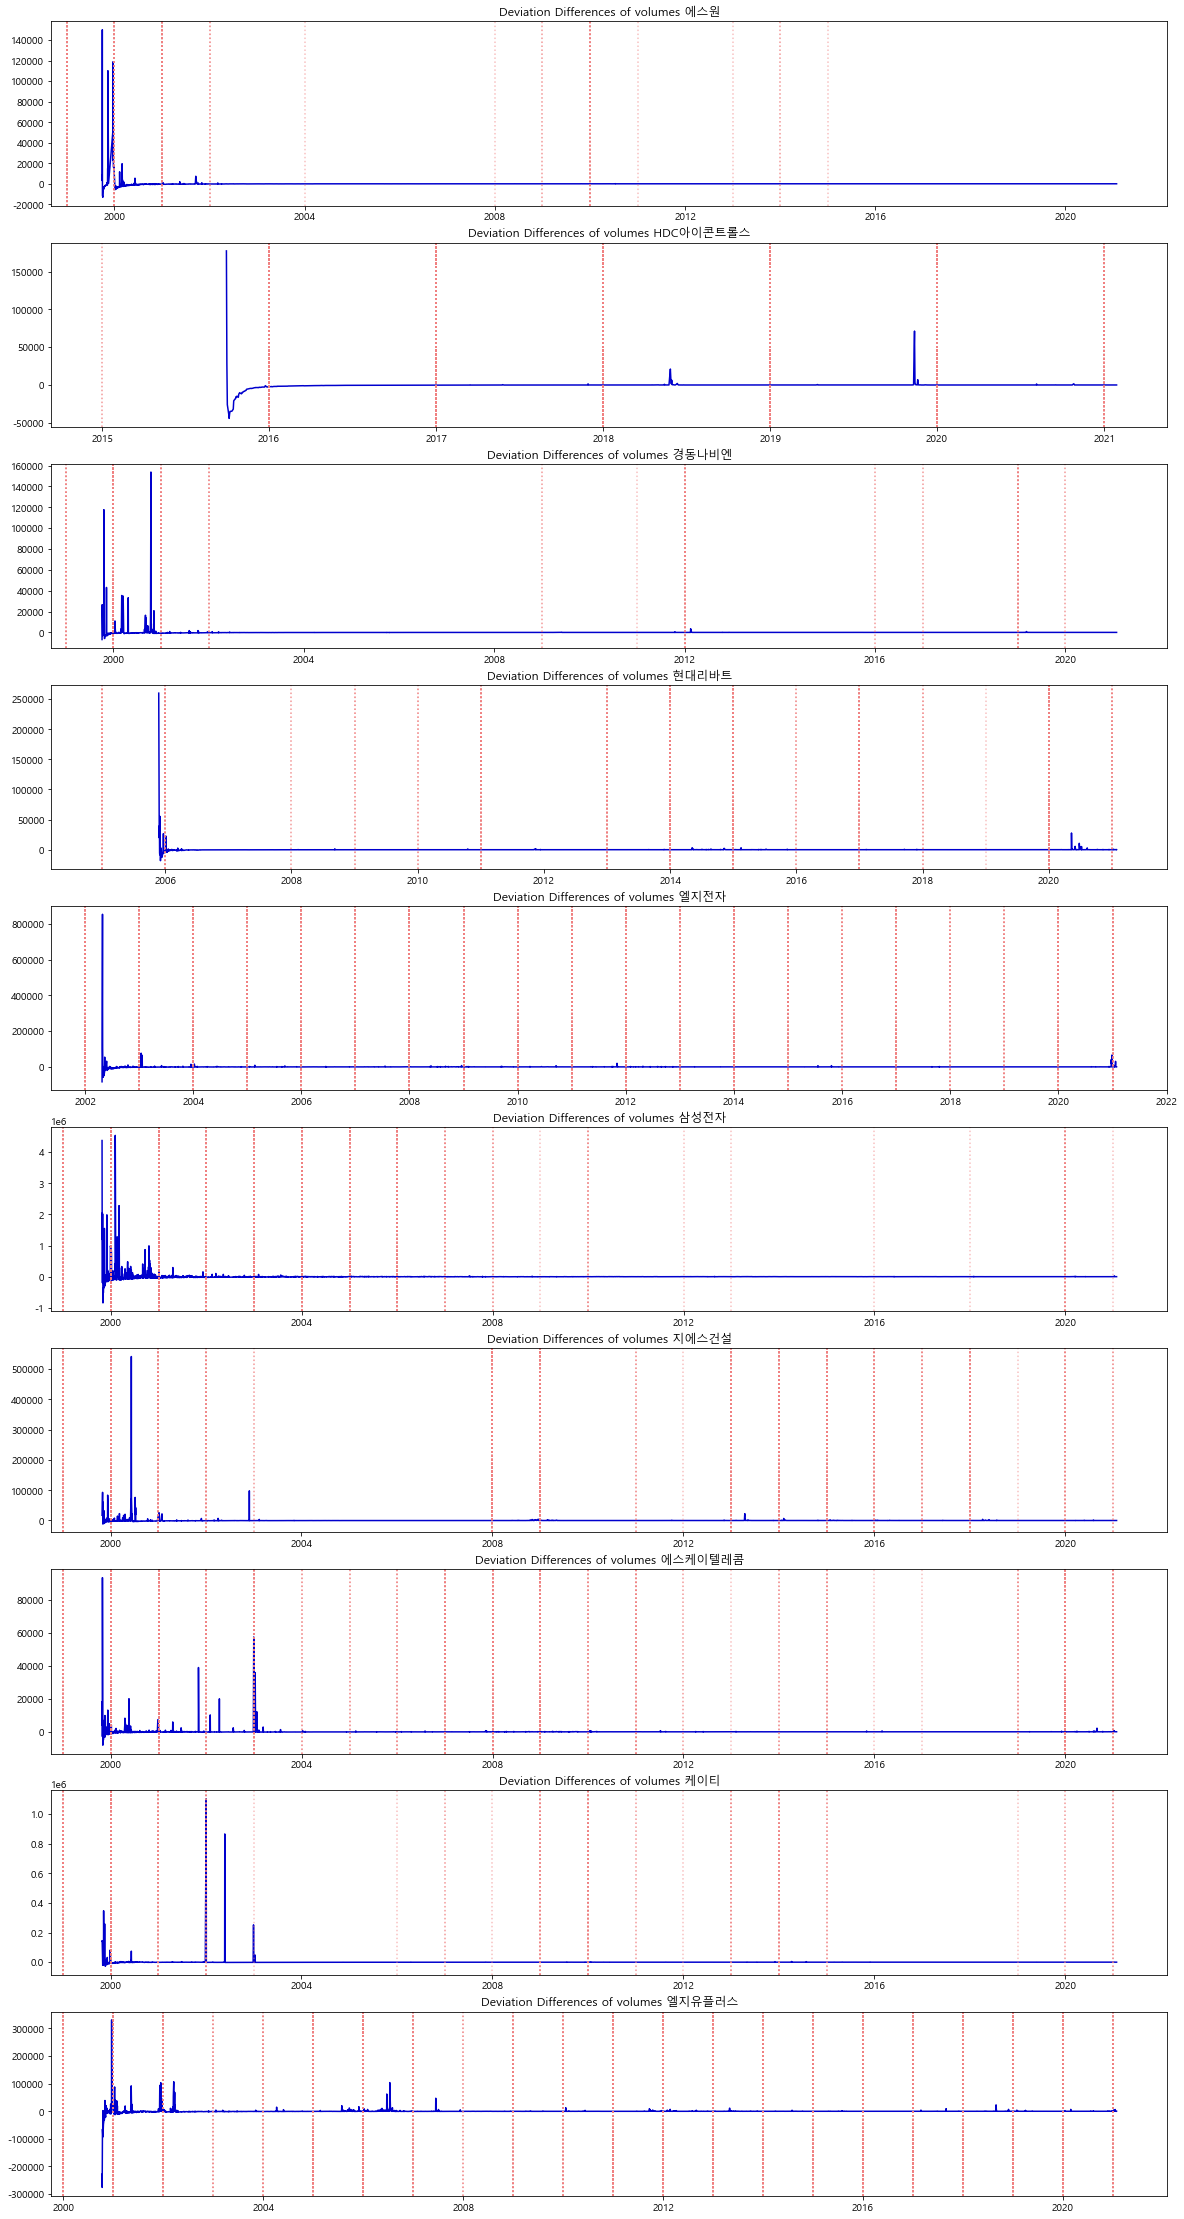

In [16]:
fig = plt.figure(figsize=(20,40))
for company in range(len(Sk_by_comp_n)):
    ax = plt.subplot(10,1,company+1)
    Test_table = Sk_by_comp_n[company].sort_values(by="date",ascending=True)
    V_deviations = pd.Series(dtype=float, index = Test_table.index)   
    
    for DT in V_deviations.index:
        wd = Test_table.loc[:DT]["volume"]
        V_deviations.loc[DT] = wd.std()
        
    V_deviations_diff = V_deviations.diff().dropna()
    
    # Visualization process    
    plt.plot(V_deviations_diff, color='mediumblue')
    ax.set_title(str('Deviation Differences of volumes ' + Sk_by_comp_n[company]['symbol'][0]))
    # Relatively outstanding different periodic values        
    T = V_deviations_diff[V_deviations_diff > np.mean(V_deviations_diff)].index
    
    for i in range(len(T) -1):
        year = T[i].year
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='lightcoral', linestyle=':', alpha=0.5)

_**St3 : Based on Srima Model, monthly trend of standard deviation has been verified**_ \
_**St4 : Selecting the unique period as abnormal value**_ 

    - 회색선은_ 약 20년 동안의 거래량 정보를,
    - 파란선은_ 각 월의 거래 변화량의 트렌드 정보를,
    - 빨간 실선은, 파란선(각 월의 거래 변화량의 트렌드 정보)에 기반하여 도출한 것이며, 모든 기간 안에서 가장 특징적인 변화량을 보인 특정일자를 선별
    
<font color = "red"><center>_**빨간 실선은 일반적이지 않은 특정한 값 변화 양상 즉, 이상치 정보로 해석할 수 있으며, 본 분석가는 이상치 정보가 출연한 정보를 중심으로 보다 세밀한 트렌드탐색을 진행해 갈 것이다.**_</font><center>

In [131]:
def Finding_outliers_through_seasonal_analysis(origin_df_list, criteria, sub_df_list, col, alp):
    fig = plt.figure(figsize=(20,37))
    for j in range(10) :
        
        abnomal_list = sub_df_list[j].iloc[np.where(sub_df_list[j][col] == 1)].index.tolist()
        
        Sk_by_comp_n_each = origin_df_list[j].copy()
        Sk_by_comp_n_each['month_trend'] = None
        SARIMA_t = []
        for i in range(len(Sk_by_comp_n_each)):
            # 20년 동안의 각 회사별 각 Month(1월 ~ 12월) volume(거래량) 정보에 대한 std 산출             
            M_deviations = Sk_by_comp_n_each[criteria].groupby(lambda x : x.month).std()
            # 각 Month(1월 ~ 12월) volume(거래량)의 std 정보에 대한 diff 산출            
            t = M_deviations.diff()
            # diff 값이 가장 큰 월에 대한 정보들을 본 데이터 프레임에서 True / False로 구분            
            SARIMA_t.append(Sk_by_comp_n_each.index[i].month == np.where(t == M_deviations.diff().max())[0][0] +1)

            if  Sk_by_comp_n_each.index[i].month == 1:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[1]
            elif Sk_by_comp_n_each.index[i].month == 2:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[2]
            elif Sk_by_comp_n_each.index[i].month == 3:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[3]
            elif Sk_by_comp_n_each.index[i].month == 4:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[4]
            elif Sk_by_comp_n_each.index[i].month == 5:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[5]
            elif Sk_by_comp_n_each.index[i].month == 6:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[6]
            elif Sk_by_comp_n_each.index[i].month == 7:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[7]
            elif Sk_by_comp_n_each.index[i].month == 8:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[8]
            elif Sk_by_comp_n_each.index[i].month == 9:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[9]
            elif Sk_by_comp_n_each.index[i].month == 10:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[10]
            elif Sk_by_comp_n_each.index[i].month == 11:
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[11]
            else: 
                Sk_by_comp_n_each['month_trend'][i] = M_deviations[12]
                
        # month_trend : 약 20년 동안의 거래량 정보 중 각 월(1월 ~ 12월) 거래량의 대표값을 추정하였으며,
        # month_trend.approx(Approximation) : 해당 정보의 근사값을 도출하여 각 회사 주식정보 DataFrame에 적재.                
        Sk_by_comp_n_each['month_trend_approx'] = pd.to_numeric(Sk_by_comp_n_each['month_trend'],errors = 'coerce').round()
         # month_trend 중 대표 월을 선정하기 위해, trend에 대한 특성이 가장 두드러진 월 정보만을 구분하여 추출        
        result = Sk_by_comp_n_each.loc[Sk_by_comp_n_each.index[SARIMA_t]].sort_values(by='date',ascending=True)[criteria]    

        # 해당 일자를 제외한 나머지 일자 간의 std 값 중 가장 작은 값을 유도하는 일자가 가장 거래량의 변화가 큰 기간으로 추정
        # 위와 같은 논리로, Anomaly detection 진행        
        SARIMA_std = []
        value_anomaly = []
        for dte in result.index:
            stdt = result[result.index != dte]
            SARIMA_std.append(stdt.std())
        d = {'col1': result.index, 'col2': SARIMA_std}    
        dev_frame = pd.DataFrame(d)
        value_anomaly_x = dev_frame[dev_frame['col2'] == min(SARIMA_std)]['col1']
        a = str(value_anomaly_x)
        t = pd.DataFrame({'year' : [a.split('-')[0][-4:]], 'month' : [a.split('-')[1]], 'day' : [a.split('-')[2][0:2]]})
        value_anomaly_n = pd.to_datetime(t)
        
        # 반복적으로 시각화를 진행   
        ax = plt.subplot(10,1,j+1)
        plt.plot(origin_df_list[j][criteria], color='gray',label='Original')
        plt.axvline(value_anomaly_n, color='red', linestyle=':', alpha=1, lw = 2)
        plt.annotate(f'Among those multiple abnoromal detection, {value_anomaly_n} is a rather unique one',
                     color='red',
                     fontsize=15,
                     xy=(value_anomaly_n, round(np.median(origin_df_list[j][criteria]))), xycoords='data',
                     xytext=(100, 60), textcoords='offset points',
                     size=12,
                     arrowprops=dict(arrowstyle="simple",
                                     fc="0.6", ec="none",
                                     connectionstyle="arc3,rad=0.3"))
        plt.plot(Sk_by_comp_n_each['month_trend_approx'], color='mediumblue', lw=3, label='Original')
        
        [plt.axvline(x=new_i, color='darkviolet', alpha=alp, linestyle='--') for new_i in abnomal_list]
        ax.set_title(str(origin_df_list[j]['symbol'][0]))

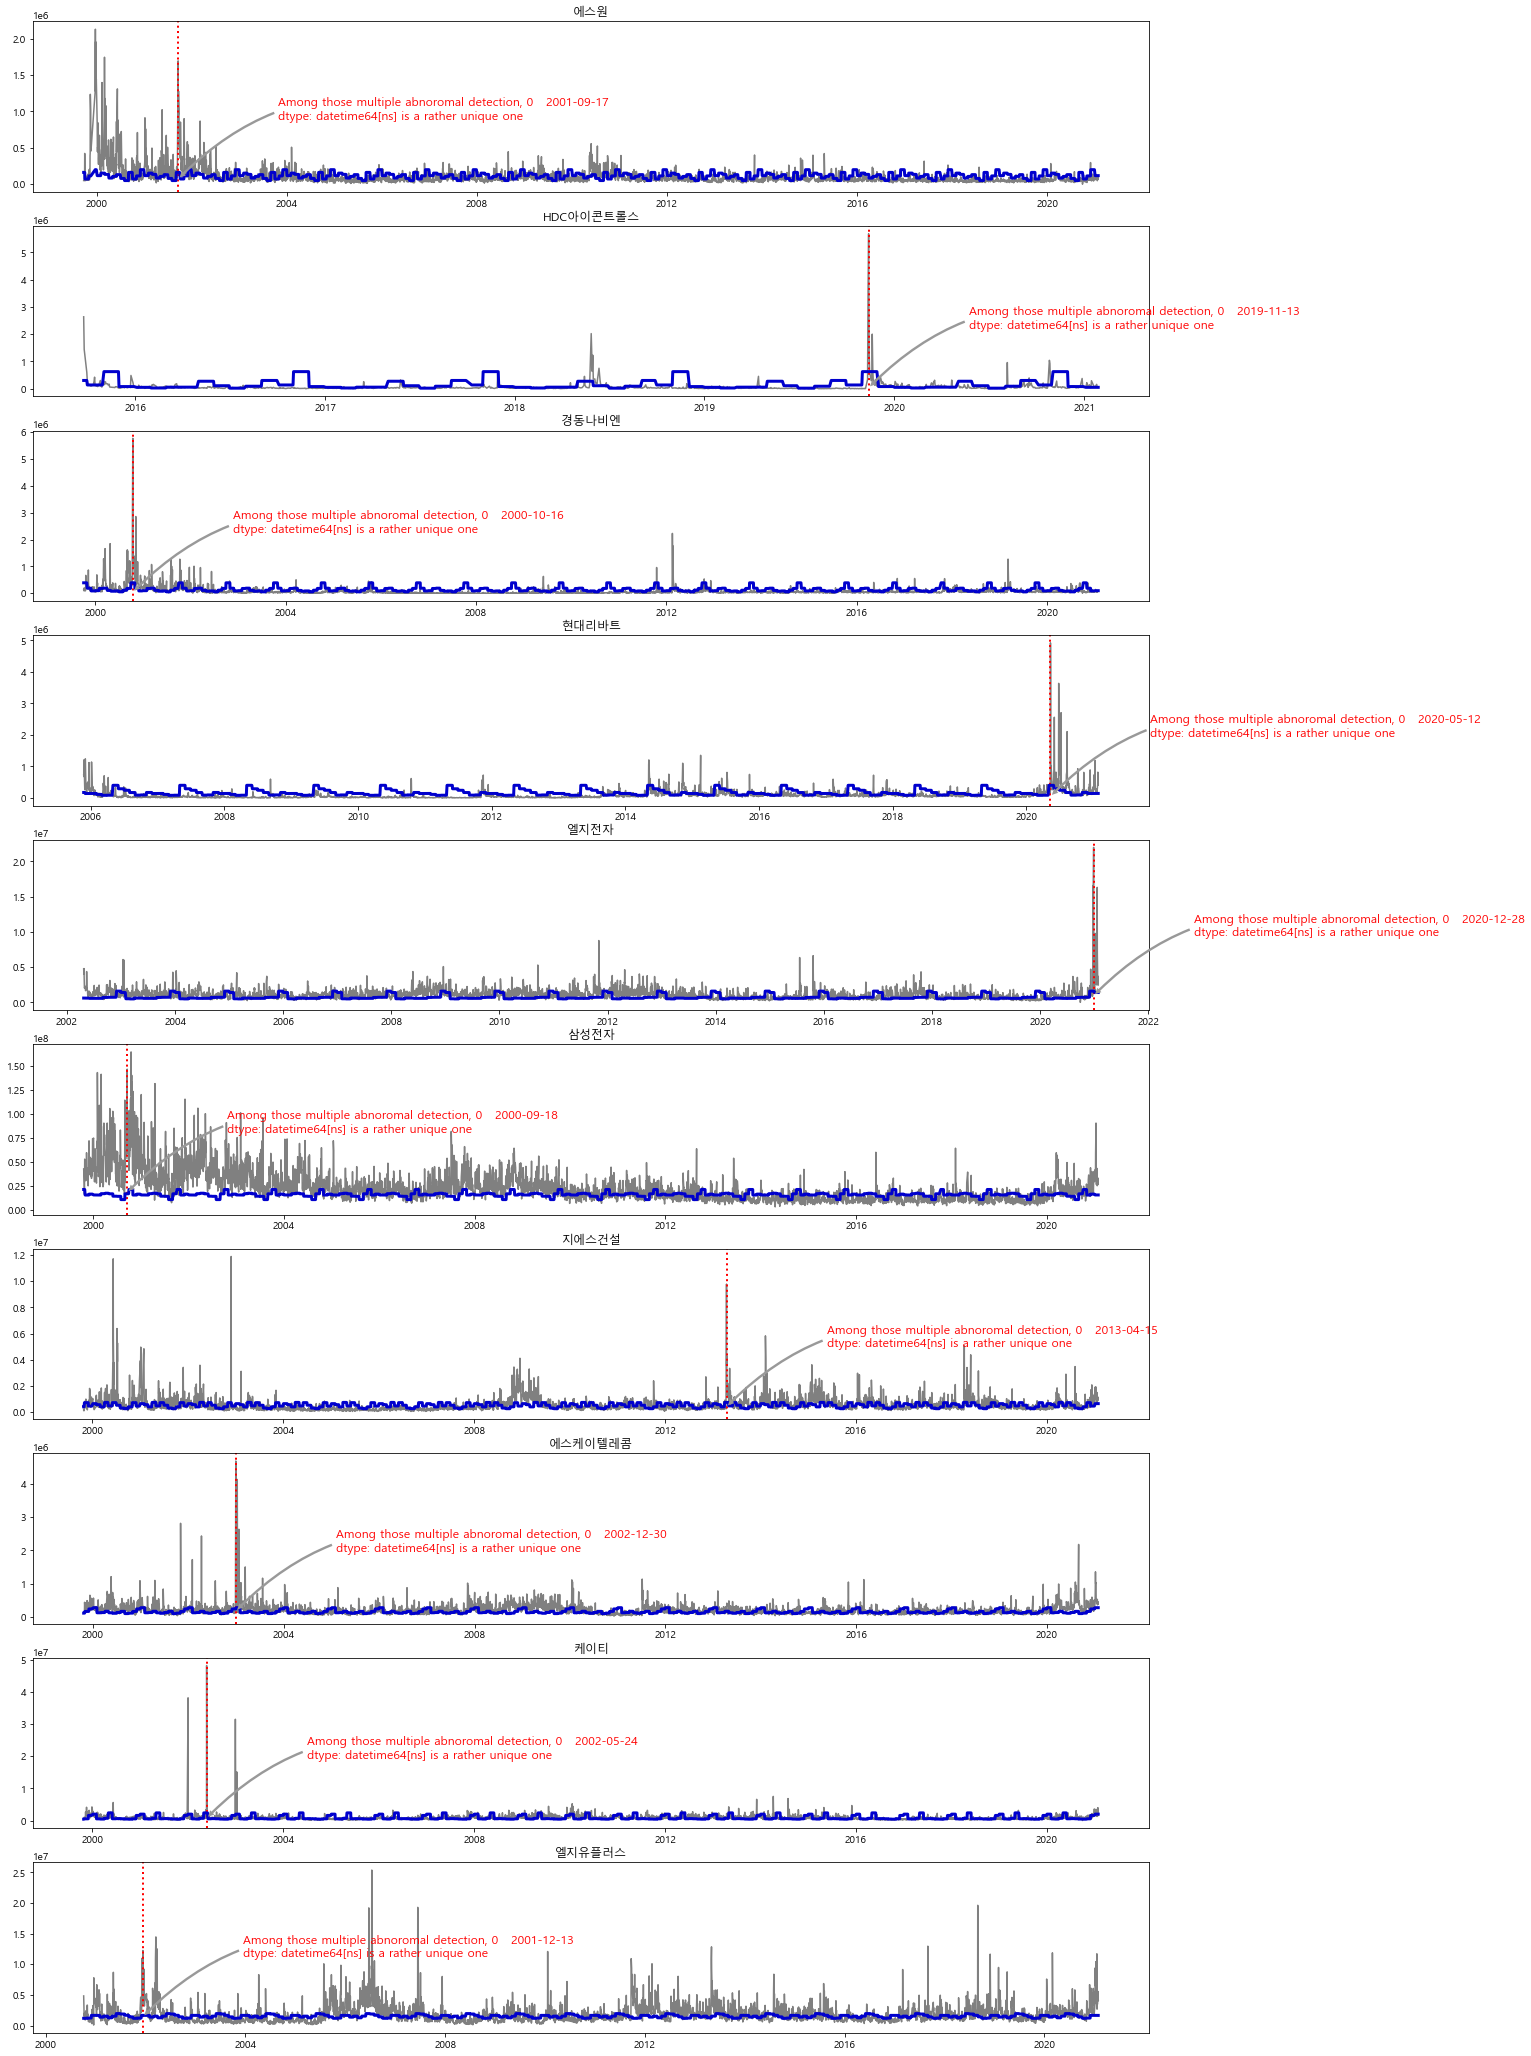

In [132]:
Finding_outliers_through_seasonal_analysis(Sk_by_comp_n, 'volume', Sk_by_comp_n, 'volume', 0)

---

**<center><font color = 'blue'>Comparing change in value of abnormal value and Drawdown value through Isolation Forest.</center>**

아래 그림은 Drawdown과 그 기간, 그리고 저점에서부터의 회복기간에 대해 잘 설명해주고 있는 그림으로 장기투자를 하는 경우 역사적으로 몇번의 Drawdown이 일어났는지, 그 하락폭은 어느정도였는지, 회복하는 기간은 어느정도였는지, 전고점으로부터 주가가 하락하기 시작하여 회복하기까지 총 어느정도가 소요됐는지는 알아보면서 그 기간에 기업에 있었던 중요한 사건을 기록해두는 것은 투자에 중요한 요소이다.

***The picture below illustrates period of Drawdown, as well as recovery period from the lowest point. When doing long-term investment, it is crucial that investors keep the record of how many times Drawdown has occurred, how long did it take to recover, as well as how long did it take to recover from previous high point.*** 

<center><img src="./Image/Draw_down.PNG" width=600 height=700></center>

_**<center><font color = 'slategrey'>Draw Down</center>**_

_**<center>I was able to produce a reult, which is abnormal value that can be detected with 5% robability.</center>**_
_**<center>it showed cominated result.it showed cominated result.</center>**_

In [81]:
def Create_new_df_volume(Selecting_cp, End_date):    
    Selecting_vol = []
    for company in range(10):
        cp_name = str(Sk_by_comp_n[company]['symbol'][0])
        if cp_name in Selecting_cp:
            # st_date_loc = np.where(Sk_by_comp_n[company].sort_values(by='date', ascending=True).index == pd.to_datetime(Start_date))[0][0] 
            ed_date_loc = np.where(Sk_by_comp_n[company].sort_values(by='date', ascending=True).index == pd.to_datetime(End_date))[0][0]
            Selecting_vol.append(pd.DataFrame(Sk_by_comp_n[company].sort_values(by='date', ascending=True).iloc[:ed_date_loc,5])) 
    return Selecting_vol

Sel_cp_df = Create_new_df_volume(stock_name_list, '2021-01-28')
for i in range(10):
    print('거래기록 시작일', Sel_cp_df[i].index[0])
    print('거래기록 종료일', Sel_cp_df[i].index[-1], Sk_by_comp_n[i]['symbol'][0])
    print('-'*50)

def iforest_func(nth, contamination):
    Classifier = IsolationForest(n_estimators=100, max_samples='auto', contamination=contamination, \
                                     max_features=1.0, bootstrap=False, n_jobs=-1, random_state=None, verbose=0)
    Classifier.fit(Sel_cp_df[nth][['volume']])
    Sel_cp_df[nth]['Scores'] = Classifier.decision_function(Sel_cp_df[nth][['volume']])
    
    # Classifier and Prediction of Network Abnormal Data(CPNAD)
    Sel_cp_df[nth]['CPNAD'] = Classifier.predict(Sel_cp_df[nth][['volume']])
    Sel_cp_df[nth].loc[Sel_cp_df[nth]['CPNAD'] == 1, 'CPNAD'] = 0
    Sel_cp_df[nth].loc[Sel_cp_df[nth]['CPNAD'] == -1, 'CPNAD'] = 1
    Sel_cp_df[nth]['CPNAD'].value_counts()
    
for nth in range(10):
    iforest_func(nth, float(.005))
    time.sleep(2)     

거래기록 시작일 1999-09-22
거래기록 종료일 2021-01-27 에스원
--------------------------------------------------
거래기록 시작일 2015-09-24
거래기록 종료일 2021-01-27 HDC아이콘트롤스
--------------------------------------------------
거래기록 시작일 1999-10-05
거래기록 종료일 2021-01-27 경동나비엔
--------------------------------------------------
거래기록 시작일 2005-11-23
거래기록 종료일 2021-01-27 현대리바트
--------------------------------------------------
거래기록 시작일 2002-04-24
거래기록 종료일 2021-01-27 엘지전자
--------------------------------------------------
거래기록 시작일 1999-10-21
거래기록 종료일 2021-01-27 삼성전자
--------------------------------------------------
거래기록 시작일 1999-10-26
거래기록 종료일 2021-01-27 지에스건설
--------------------------------------------------
거래기록 시작일 1999-10-22
거래기록 종료일 2021-01-27 에스케이텔레콤
--------------------------------------------------
거래기록 시작일 1999-10-26
거래기록 종료일 2021-01-27 케이티
--------------------------------------------------
거래기록 시작일 2000-10-06
거래기록 종료일 2021-01-27 엘지유플러스
--------------------------------------------------


***Add_srima_result to iforest***

In [82]:
list_value_anomaly = ['2001-09-17',
                      '2019-11-13',
                      '2000-10-16',
                      '2020-05-12',
                      '2020-12-28',
                      '2000-09-18',
                      '2013-04-15',
                      '2002-12-30',
                      '2002-05-24',
                      '2001-12-13']

df = []
for j in range(10):
    terminer_df = Sel_cp_df[j].copy()
    Sr_date = pd.to_datetime(list_value_anomaly[j])
    ab_result = []
    for i in range(len(terminer_df)):
        
        if terminer_df.index[i] == Sr_date:
            ab_result.append(float(1))
            Sel_cp_df[j]
        else:
            ab_result.append(float(0))
    Sel_cp_df[j]['result_by_Sarima'] = ab_result

In [84]:
def plot_anomaly(nth, metric_name):
    from plotly.subplots import make_subplots
    Sel_cp_df[nth]['Timestamp'] = Sel_cp_df[nth].index
    Sel_cp_df[nth]['Adj_close'] = Sk_by_comp_n[nth]['adj_close'].copy()
    dates = Sel_cp_df[nth].index
    
    # Drawdown을 위해 가장 적합한 window 단위를 탐색     
    count_year = []
    sub_df = pd.DataFrame()
    for idx, row in pd.DataFrame(Sel_cp_df[nth]['Adj_close']).iterrows():
        count_year.append(idx.year)
    sub_df['year'] = count_year
    window = int(sub_df.value_counts().median())      
    # Calculate the max drawdown in the past window days for each day 
    rolling_max = Sel_cp_df[nth]['Adj_close'].rolling(window, min_periods=1).max()
    daily_drawdown = Sel_cp_df[nth]['Adj_close']/rolling_max - 1.0
    # Optional_rolling      
    max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()  
  
    
    bool_array = (abs(Sel_cp_df[nth]['CPNAD']) > 0)
    actuals = Sel_cp_df[nth]["volume"][-len(bool_array):]
    CPNAD_points = bool_array * actuals
    CPNAD_points[CPNAD_points == 0] = np.nan
    
    bool_array_SRIMA = (abs(Sel_cp_df[nth]['result_by_Sarima']) > 0)
    actuals_SRIMA = Sel_cp_df[nth]["volume"][-len(bool_array_SRIMA):]
    CPNAD_points_SRIMA = bool_array_SRIMA * actuals_SRIMA
    CPNAD_points_SRIMA[CPNAD_points_SRIMA == 0] = np.nan
    

    #A dictionary for conditional format table based on anomaly
    color_map = {0: "white", 1: "crimson"}
    
    fig = make_subplots(
        rows=3, cols=1,
        row_heights=[1.0, 2, 2],
        shared_xaxes=True,
        vertical_spacing=0.05,
        specs=[[{"type": "scatter"}], [{"type": "scatter"}], [{"type": "table"}]])
    
    
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.5]),
        columnwidth=[1, 1, 1],
        header=dict(height=27,
                    values=[['<b>날짜</b>'], ['<b>일별 거래량</b>'], ['<b>Adj_close (액면분할, 배당금, 권리 등 추가고려)</b>'],],
                    font=dict(color='black', size=10),
                    fill=dict(color='silver')),
        cells=dict(values=[Sel_cp_df[nth].round(3)[k].tolist() for k in ['Timestamp', 'volume', 'Adj_close']],
                   line=dict(color='white'),
                   align=['center'],
                   font=dict(size=12),
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   fill=dict(color=[Sel_cp_df[nth]['CPNAD'].map(color_map)])))
    
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=Sel_cp_df[nth]['volume'],
                         xaxis='x1', 
                         yaxis='y1',
                         mode='lines',
                         marker=dict(size=12, line=dict(width=2), color="gray"))
    
    anomalies_map = go.Scatter(name="Abnormal_value_by_IForest",
                               showlegend=True,
                               x=dates,
                               y=CPNAD_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red", size=10, line=dict(width=2)))
    
    anomalies_Sariam = go.Scatter(name="Abnormal_value_by_Sarima",
                                  showlegend=True,
                                  x=dates,
                                  y=CPNAD_points_SRIMA,
                                  mode='markers',
                                  xaxis='x1',
                                  yaxis='y1',
                                  marker=dict(color="blue", size=10, line=dict(width=2)))
    
    
    daily_drawdown_1 = go.Scatter(name='Daily_Drawdown',
                                  showlegend=True,
                                  mode='lines',
                                  x=dates,
                                  xaxis='x1',
                                  yaxis='y1',                           
                                  y=daily_drawdown,
                                  marker=dict(size=10, line=dict(width=1), color="dodgerblue"), fill='tonexty')
    
    daily_drawdown_2 = go.Scatter(name='Rolling_Drawdown',
                                  showlegend=True,
                                  mode='lines',
                                  x=dates,
                                  xaxis='x1',
                                  yaxis='y1',                           
                                  y=max_daily_drawdown,
                                  line = dict(color='crimson', width=3, dash='dot'), fill='tonexty')
       
    axis = dict(ticklen=4,gridcolor='white',tickfont=dict(size=10))
    a_group = go.Figure(data=[anomalies_map, anomalies_Sariam, Actuals])
    b_group = go.Figure(data=[daily_drawdown_1, daily_drawdown_2])
    for k1 in range(len(a_group.data)):
         fig.add_trace(a_group.data[k1], row=1, col=1)      
    for k2 in range(len(b_group.data)):
        fig.add_trace(b_group.data[k2], row=2, col=1)       
    fig.add_trace(table, row=3, col=1)
    Sarima_results = pd.to_datetime(list_value_anomaly[nth])
    fig.update_layout(
        width=1100,
        height=620,
        showlegend=True,
        plot_bgcolor='white',
        title_text=metric_name)
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', showticklabels=False, mirror=True, gridcolor='whitesmoke')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, gridcolor='whitesmoke')
    iplot(fig)
            
for idx in range(10):
    plot_anomaly(idx, stock_name_list[idx])
    time.sleep(2)

---

In [35]:
# stock_code_list
# ['012750',
#  '039570',
#  '009450',
#  '079430',
#  '066570',
#  '005930',
#  '006360',
#  '017670',
#  '030200',
#  '032640']

# stock_code_list
# ['에스원',
#  'HDC아이콘트롤스',
#  '경동나비엔',
#  '현대리바트',
#  '엘지전자',
#  '삼성전자',
#  '지에스건설',
#  '에스케이텔레콤',
#  '케이티',
#  '엘지유플러스']

Short_sell_list = []
for i in range(len(stock_code_list)):
    Short_sell_list.append(stock.get_shorting_volume_by_date("20000104", "20210108", f"{stock_code_list[i]}"))

In [36]:
for list_num in range(len(stock_code_list)):
    Short_sell_list[list_num]['symbol'] = stock_name_list[list_num]

In [37]:
tail_list_to_check = []

for i in range(len(Short_sell_list)):
    tail_list_to_check.append(Short_sell_list[i].tail(1))
short_sell_r = pd.concat(tail_list_to_check, axis=0)
short_sell_r

,공매도,매수,비중,symbol
날짜,,,,
2021-01-08,55,135607,0.04,에스원
2021-01-08,13,94526,0.01,HDC아이콘트롤스
2021-01-08,0,132677,0.00,경동나비엔
2021-01-08,39,336278,0.01,현대리바트
2021-01-08,45,9472733,0.00,엘지전자
2021-01-08,6,59013307,0.00,삼성전자
2021-01-08,8400,1736980,0.48,지에스건설
2021-01-08,1739,1005900,0.17,에스케이텔레콤
2021-01-08,1667,2928759,0.06,케이티


In [38]:
for nth in range(len(Short_sell_list)):
    Short_sell_list[nth].index.names = ['date']
    Short_sell_list[nth].rename(columns = {'공매도': 'Short_selling'}, inplace = True)

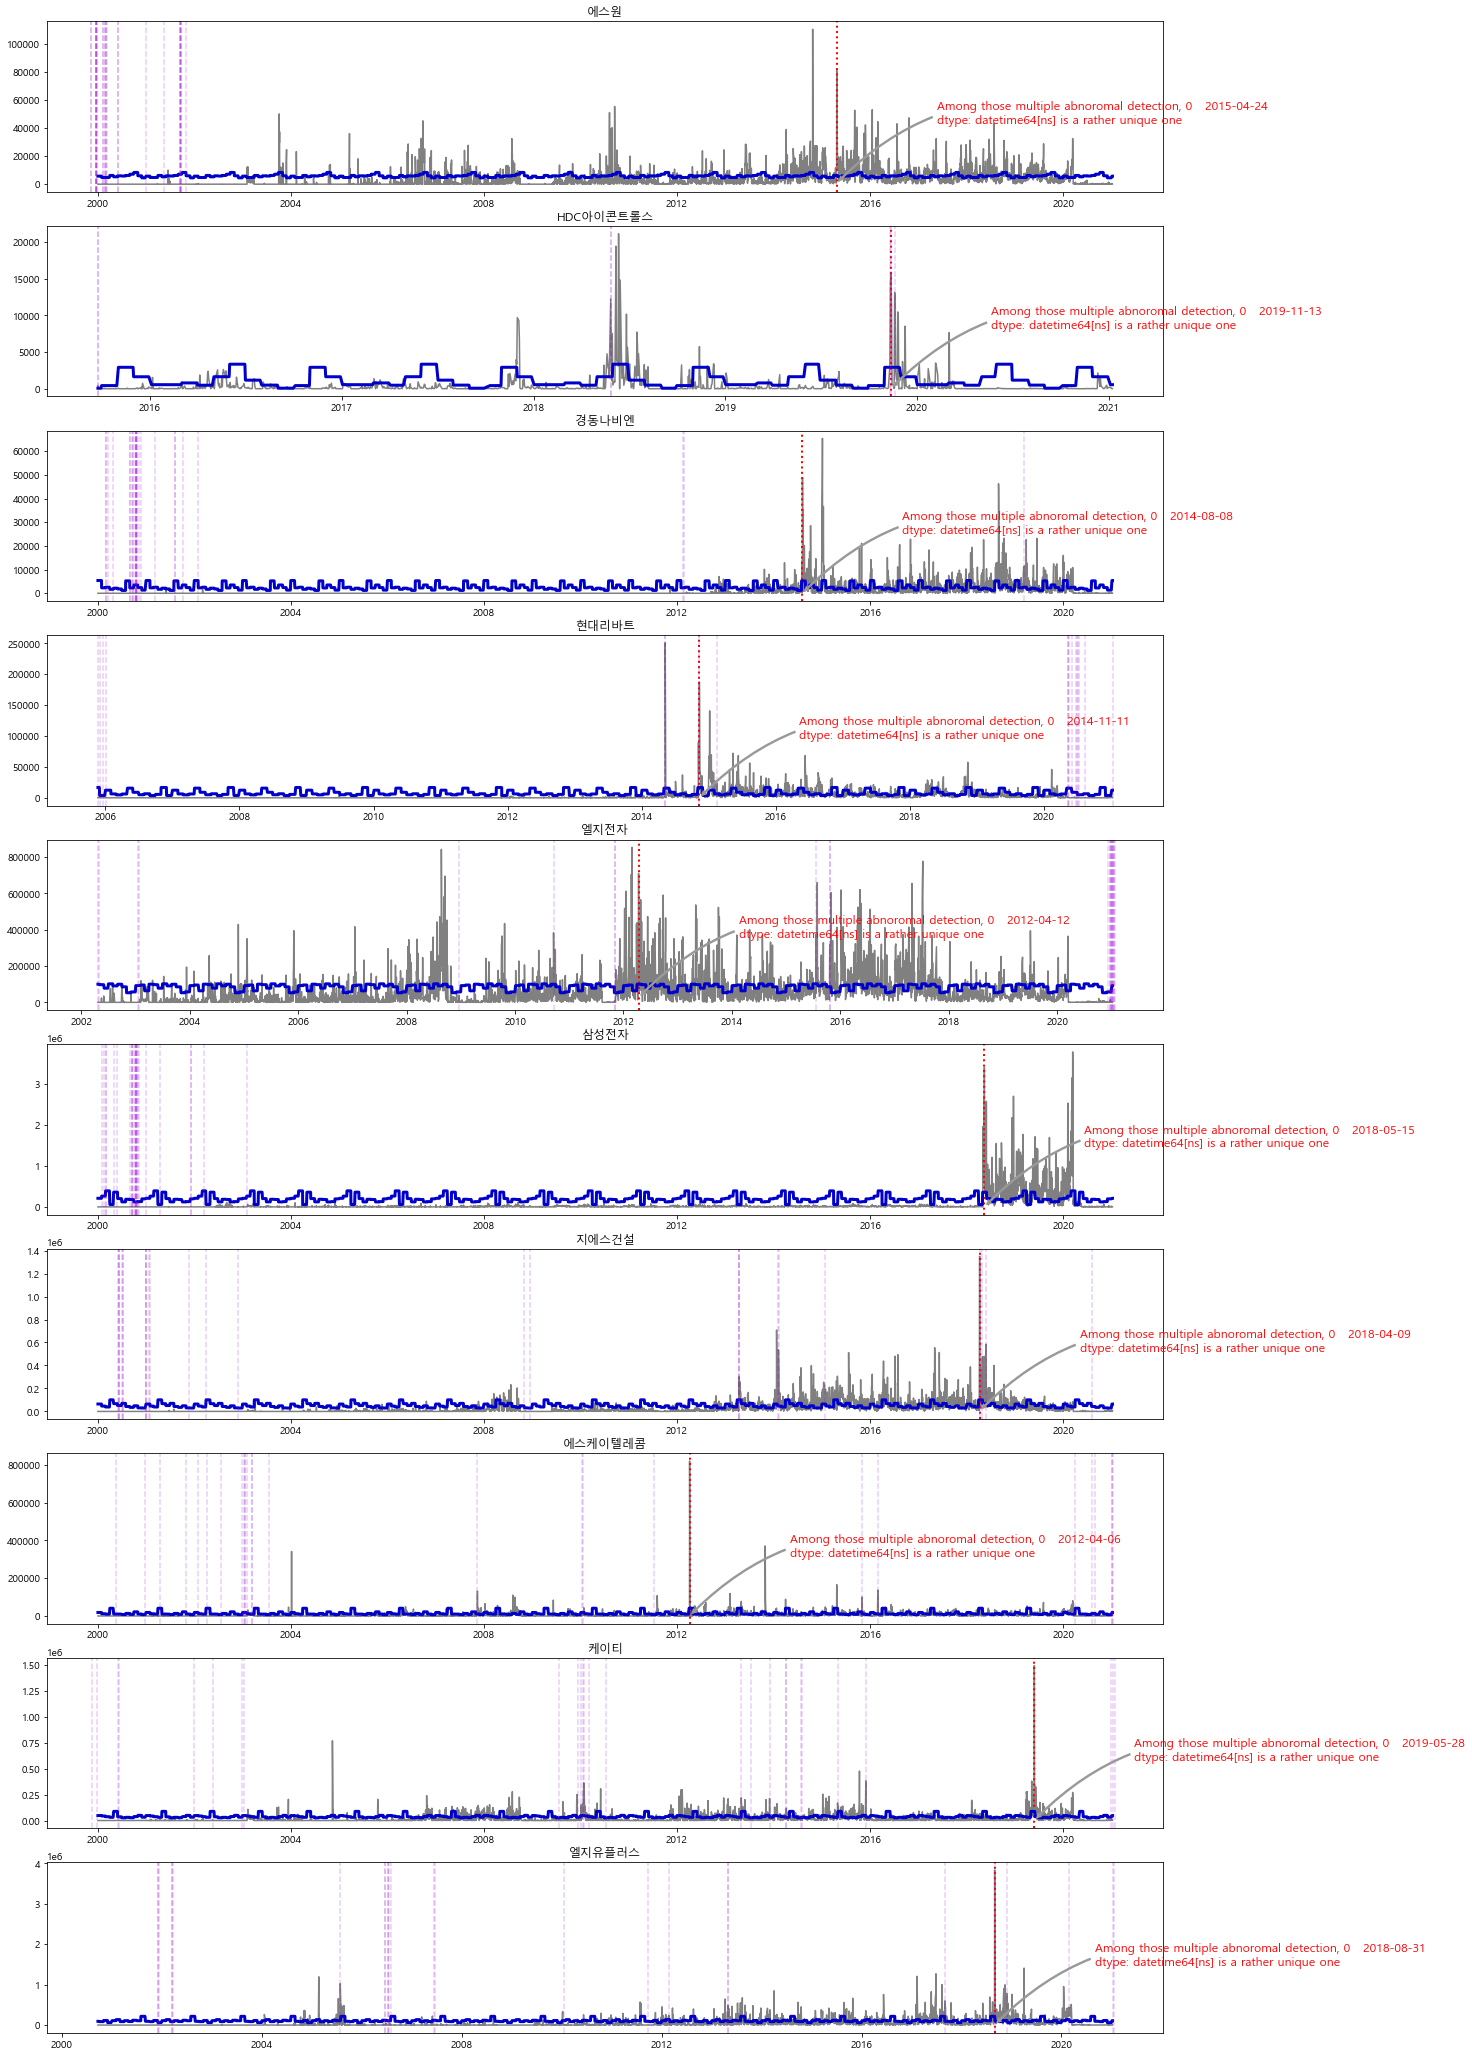

In [133]:
Finding_outliers_through_seasonal_analysis(Short_sell_list, 'Short_selling', Sel_cp_df, 'CPNAD', 0.2)

***지표생성 및 분류분석*** \
    - XGBoost \
    - Lightgbm \
    - RandomForest

_**1St**_ : 특정 지표 선택 및 선택 기준 소개 

In [106]:
# Copy the dateframe list
Creating_technical_indicator = []
for i in range(10):
     Creating_technical_indicator.append(Sk_by_comp_n[i].sort_values(by='date', ascending=True).copy())

In [107]:
# Create_indicator1 -- MFI
def money_flow_index(nth, period=14):
    mdf = Creating_technical_indicator[nth]
    typical_price = (mdf['close'] + mdf['high'] + mdf['low']) / 3
    money_flow = typical_price * mdf['volume']
    
    positive_flw = []
    negative_flw = []
    
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flw.append(money_flow[i-1])
            negative_flw.append(0)
        elif typical_price[i] < typical_price[i-1]:
            negative_flw.append(money_flow[i-1])
            positive_flw.append(0)
        else:
            negative_flw.append(0)
            positive_flw.append(0)

    positive_mflw = []
    negative_mflw = []
            
    for i in range(period-1, len(positive_flw)):
        positive_mflw.append( sum(positive_flw[i+1-period:i+1]) )
    for i in range(period-1, len(negative_flw)):
        negative_mflw.append( sum(negative_flw[i+1-period:i+1]) )     

    mfi = 100 * (np.array(positive_mflw) / (np.array(positive_mflw) + np.array(negative_mflw)))
    Creating_technical_indicator[nth]['mfi'] = np.nan
    Creating_technical_indicator[nth][14:]['mfi'] = mfi.tolist() 
    Creating_technical_indicator[nth]['mfi'].fillna(0, inplace = True)
    
for i in range(10):
    money_flow_index(i, 14)

   
# OBV, OBV_EMA    
def on_balance_volume(nth, span=20):
    odf = Creating_technical_indicator[nth]
    OBV = []
    OBV.append(0)

    for i in range(1, len(odf.close)):
        if odf.close[i] > odf.close[i-1]:
            OBV.append(OBV[-1] + odf.volume[i])
        elif odf.close[i] < odf.close[i-1]:
            OBV.append(OBV[-1] - odf.volume[i])
        else:
            OBV.append(OBV[-1])
            
    Creating_technical_indicator[nth]['obv'] = OBV
    Creating_technical_indicator[nth]['obv_ema'] = odf['obv'].ewm(span=span).mean()

for i in range(10):
    on_balance_volume(i, span=20)


# PVI(Positive Volume Index, Positive Volume Index_ema)    
def positive_volume_index(nth, periods=240):
    pdf = Creating_technical_indicator[nth].reset_index().copy()
    pdf['pvi'] = 0
    pvi = []

    for idx, row in pdf.iterrows():
        if idx > 0:
            prev_pvi = pdf['pvi'][idx-1]
            prev_close = pdf['close'][idx-1]
            if row['volume'] > pdf['volume'][idx-1]:
                pvi.append(prev_pvi + (row['close'] - prev_close / prev_close * prev_pvi))
            else:
                pvi.append(prev_pvi)
        else:
            pvi.append(1000)
            
    Creating_technical_indicator[nth]['pvi'] = pvi
    Creating_technical_indicator[nth]['pvi_ema'] = Creating_technical_indicator[nth]['pvi'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()

# one-year cycle    
for i in range(10):
    positive_volume_index(i, periods=225)


# VWAP
def volume_weighted_average_price(nth):
    vdf = Creating_technical_indicator[nth].copy()
    vdf['vwap'] = np.cumsum(vdf['volume'] * (vdf['high'] + vdf['low']) / 2) / np.cumsum(vdf['volume'])
    vdf = vdf.fillna(0)
    
    Creating_technical_indicator[nth]['vwap'] = vdf['vwap'].tolist()
    Creating_technical_indicator[i]['vwap'][-1]
    
for i in range(10):
    volume_weighted_average_price(i)


# CCI(commodity_channel_index)
def commodity_channel_index(nth, n=20, weight=0.015):    
    ccdf = Creating_technical_indicator[0].copy()
    # n = 20 
    # weight = 0.015
    avg_price = (ccdf['high'] + ccdf['low'] + ccdf['close']) / 3
    cci = pd.Series((avg_price - avg_price.rolling(window=n, center=False).mean()) / (weight * avg_price.rolling(window=n, center=False).std()))
    
    Creating_technical_indicator[nth]['cci'] = cci.fillna(0)

for i in range(10):
    commodity_channel_index(i, 20, 0.015)    
 

# ATR , NATR
def average_true_range(nth, window=14):
    cdf = Creating_technical_indicator[nth].copy()
    cdf['HL'] = cdf['high'] - cdf['low']
    cdf['abs_HC'] = abs(cdf['high'] - cdf['close'].shift(1))
    cdf['abs_LC'] = abs(cdf['low'] - cdf['close'].shift(1))
    cdf['TR'] = cdf[['HL','abs_HC','abs_LC']].max(axis=1)
    cdf['ATR'] = cdf['TR'].rolling(window=14).mean()
    cdf['NATR'] = (cdf['ATR'] / cdf['close']) *100
    cdf = cdf.fillna(0)
    
    Creating_technical_indicator[nth]['atr'] = cdf['ATR'].tolist()
    Creating_technical_indicator[nth]['natr'] = cdf['NATR'].tolist()
    
for i in range(10):
    average_true_range(i, 14)

 
# ADX(Average Directional Movement Index)
# DM: Directional Movement
# DI: Directional Indicator
def average_directional_movement_index(nth, period = 14):
    axdf = Creating_technical_indicator[nth].copy()
    axdf['uptrend'] = axdf['high'] - axdf['high'].shift(1)
    axdf['downtrend'] = axdf['low'].shift(1) - axdf['low']
    axdf['blanked'] = 0
    axdf['DM_up'] = np.where((axdf['uptrend'] > axdf['downtrend']) & (axdf['uptrend'] > axdf['blanked']), axdf['uptrend'], 0)
    axdf['DM_down'] = np.where((axdf['uptrend'] < axdf['downtrend']) & (axdf['downtrend'] > axdf['blanked']), axdf['downtrend'], 0)
    axdf['DI_up'] = 100 * (axdf['DM_up'] / axdf['atr']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
    axdf['DI_down'] = 100 * (axdf['DM_down'] / axdf['atr']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
    axdf['adx'] = 100 * (abs((axdf['DI_up'] - axdf['DI_down'])/(axdf['DI_up'] + axdf['DI_down']))).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
   
    Creating_technical_indicator[nth]['adx'] = axdf['adx'].fillna(0)
    
for i in range(10):
    average_directional_movement_index(i, 14)

In [108]:
# Create new dataframe with extracted columns
for df in range(len(Creating_technical_indicator)):
                st_col_num = np.where(Creating_technical_indicator[df].columns == 'mfi')[0][0]
                lt_col_num = len(Creating_technical_indicator[df].columns)
                volume_idx = np.where(Creating_technical_indicator[df].columns == 'volume')[0][0]
                Creating_technical_indicator[df] = Creating_technical_indicator[df].iloc[:,np.r_[volume_idx, st_col_num:lt_col_num]]
print(Creating_technical_indicator[9].columns)
print('마지막 데이터프레임의 행의 수', Creating_technical_indicator[9].shape[0],' / ', '마지막 데이터프레임의 열의 수', Creating_technical_indicator[9].shape[1])

Index(['volume', 'mfi', 'obv', 'obv_ema', 'pvi', 'pvi_ema', 'vwap', 'cci',
       'atr', 'natr', 'adx'],
      dtype='object')
마지막 데이터프레임의 행의 수 5017  /  마지막 데이터프레임의 열의 수 11


<Figure size 432x288 with 0 Axes>

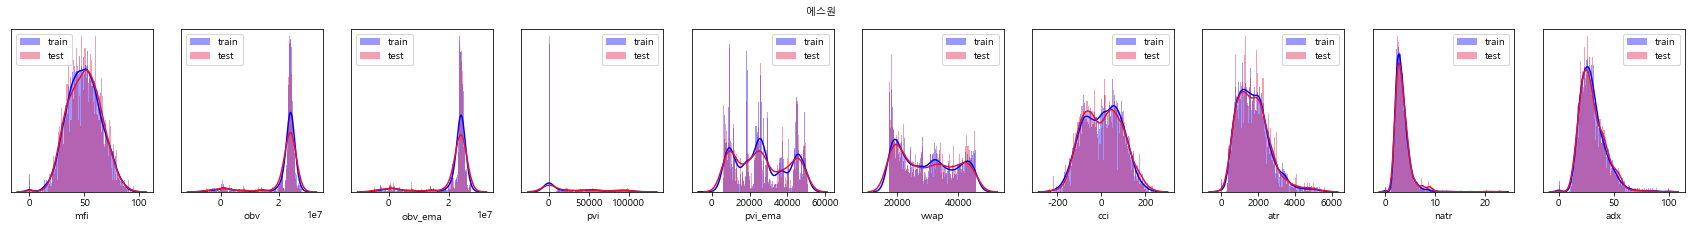

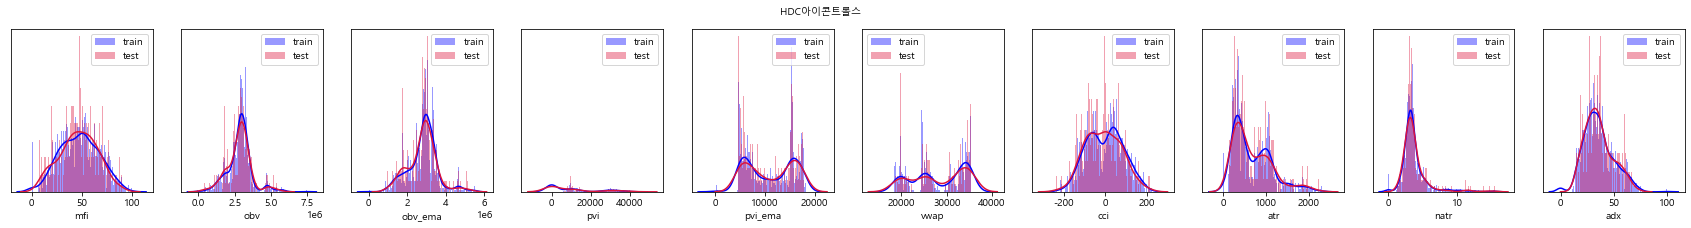

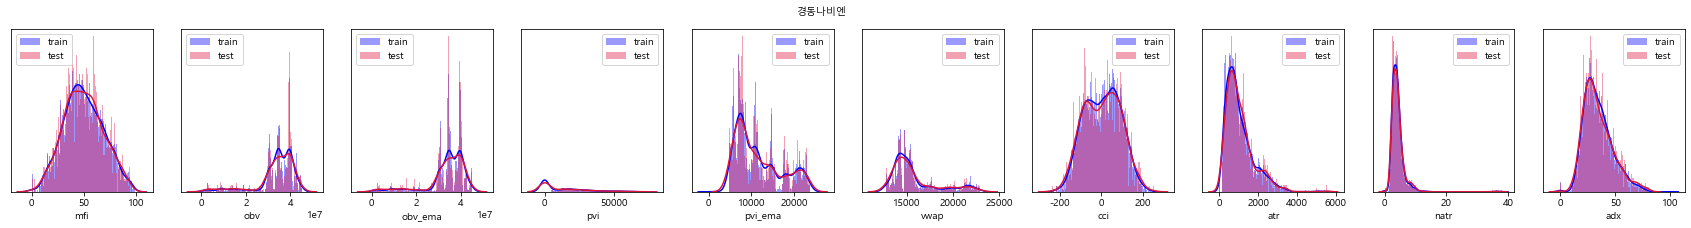

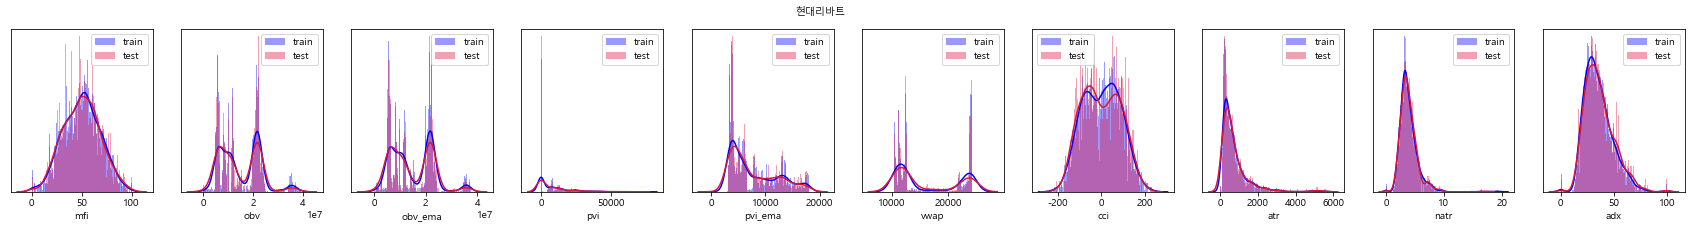

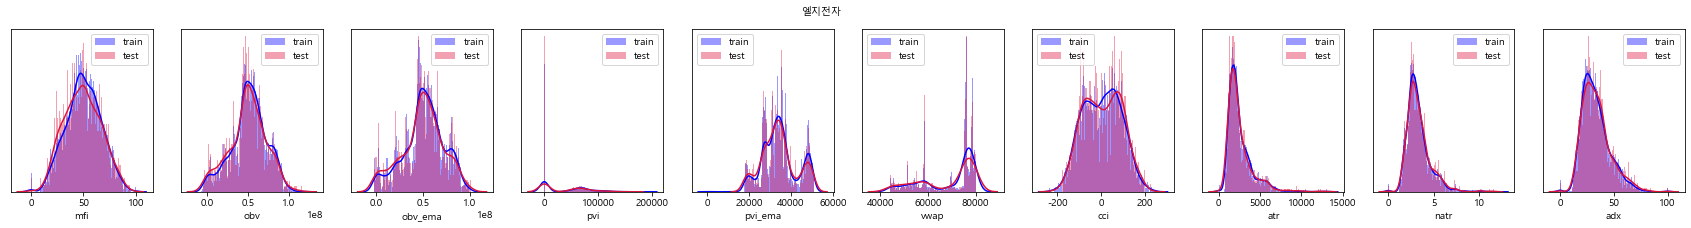

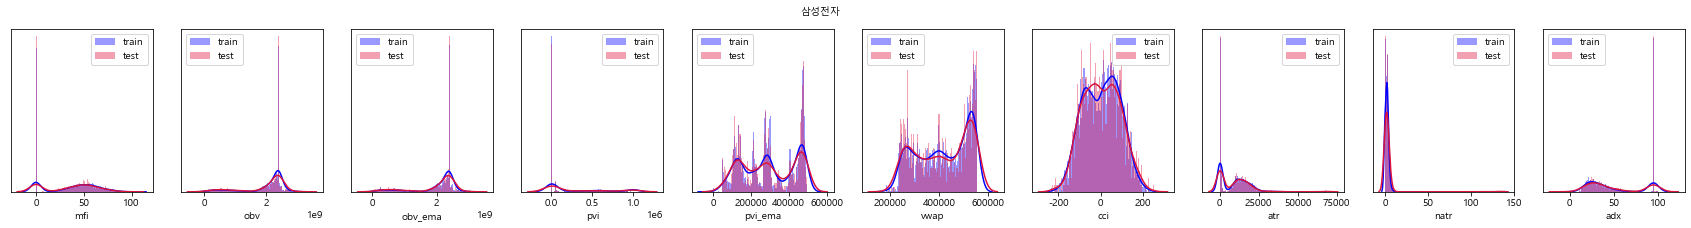

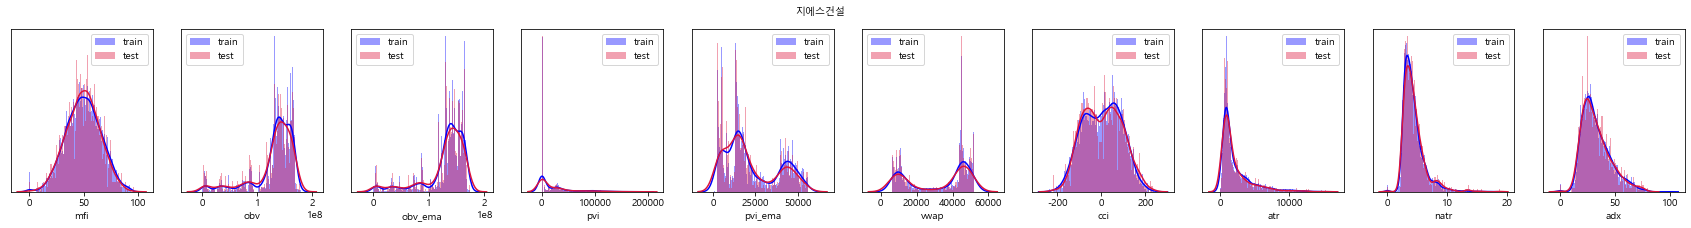

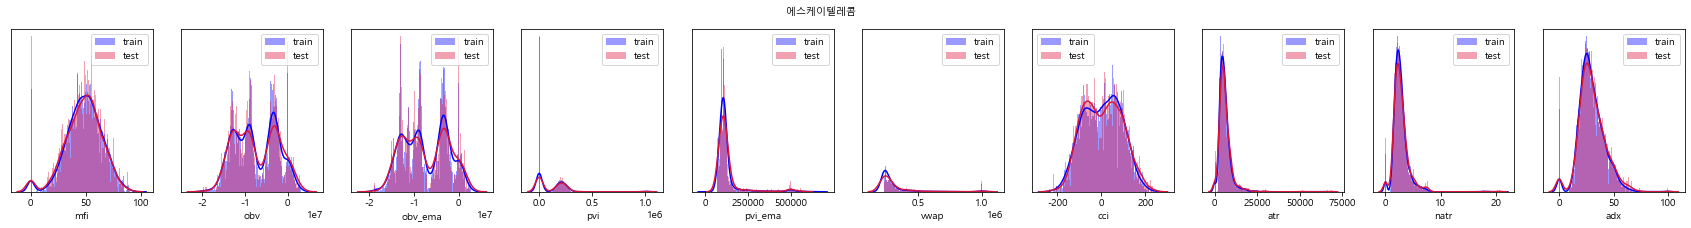

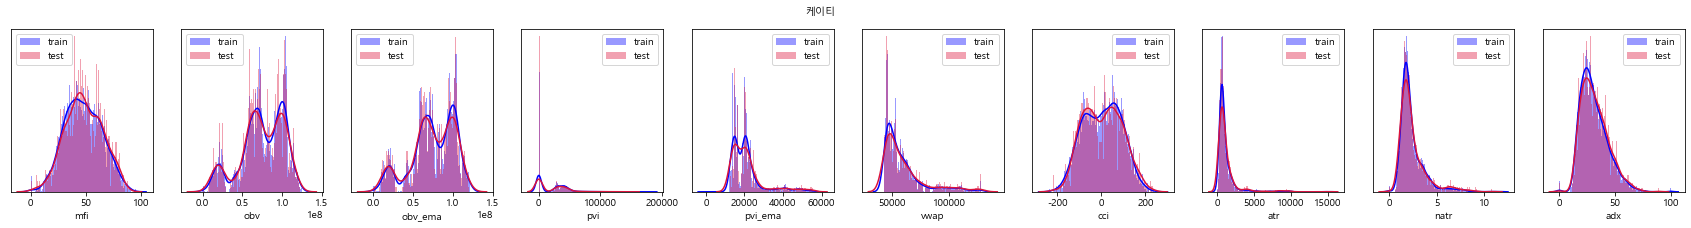

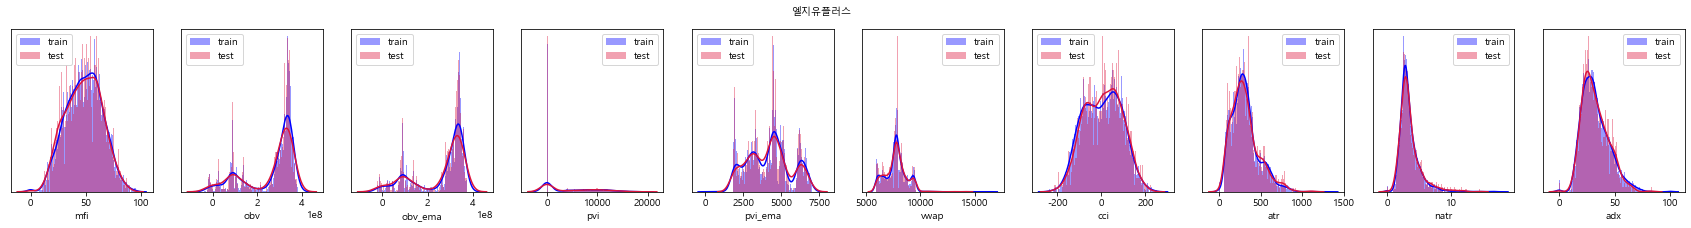

In [109]:
X = []
y = []
for indicator_df in range(len(Creating_technical_indicator)):
    df = Creating_technical_indicator[indicator_df].copy()
    X.append(df.iloc[:, 1:])
    y.append(df.iloc[:, 0])

X_train=[]
X_test= []
y_train=[]
y_test= []
df_num= 0

while df_num < 10:
    Get_Xtr, Get_Xte, Get_ytr, Get_yte = train_test_split(X[df_num], y[df_num], test_size = 0.2, random_state = 42)   
    X_train.append(Get_Xtr)
    X_test.append(Get_Xte)
    y_train.append(Get_ytr)
    y_test.append(Get_yte)
    
    df_num = df_num + 1 

plt.figure()
for j in range(10):
    fig, ax = plt.subplots(1,10,figsize=(30, 3))
    for feature in range(10):
        ax =plt.subplot(1, 10, (j-j + feature + 1))
        sns.distplot(X_train[j].iloc[:,feature], color="b", kde=True,bins=120, label='train')
        sns.distplot(X_test[j].iloc[:,feature], color="crimson", kde=True,bins=120, label='test')
        ax.axes.yaxis.set_visible(False)
        plt.legend()
    plt.suptitle(Sk_by_comp_n[j]['symbol'][0],fontsize=10)
    plt.show()    

In [110]:
# Change the column names with company_name
for Get_col in range(len(X_train)):
    selected_df_train = X_train[Get_col]    
    stock_name = stock_name_list[Get_col]
    
    for rows in range(len(selected_df_train.columns)):
        selected_df_train = selected_df_train.rename(columns = {selected_df_train.columns[rows]:str(selected_df_train.columns[rows] + '_' + stock_name)})

    X_train[Get_col] = selected_df_train

count = 0
while count < len(X_train):
    print('X_train', X_train[count].columns[0], X_train[count].columns[-1])
    count = count + 1    

X_train mfi_에스원 adx_에스원
X_train mfi_HDC아이콘트롤스 adx_HDC아이콘트롤스
X_train mfi_경동나비엔 adx_경동나비엔
X_train mfi_현대리바트 adx_현대리바트
X_train mfi_엘지전자 adx_엘지전자
X_train mfi_삼성전자 adx_삼성전자
X_train mfi_지에스건설 adx_지에스건설
X_train mfi_에스케이텔레콤 adx_에스케이텔레콤
X_train mfi_케이티 adx_케이티
X_train mfi_엘지유플러스 adx_엘지유플러스


In [111]:
# Merging dataframe by date
a = reduce(lambda left,right: pd.merge(left,right,on='date'), X_train)

# make function rep
def np_rep(x, reps=1, each=False, length=0):
    if length > 0:
        reps = np.int(np.ceil(length / x.size))
    x = np.repeat(x, reps)
    if(not each):
        x = x.reshape(-1, reps).T.ravel() 
    if length > 0:
        x = x[0:length]
    return(x)

indicator_list = ['mfi', 'obv', 'obv_ema', 'pvi', 'pvi_ema', 'vwap', 'cci', 'atr', 'natr', 'adx']

# Multi_indexing
multi_index = pd.MultiIndex.from_arrays([np_rep(np.array(indicator_list), reps=10, each=False).tolist(),
                                         np.repeat(np.asarray(stock_name_list),10, axis=0).tolist()],
                                        names=['stock_indicator', 'company'])
a.columns = multi_index 

# Multi_indexing 된 '열' 결과확인
col_component_1 = []
col_component_2 = []
for i in range(len(a.columns)):
    col_component_1.append(a.columns[i][0])
    col_component_2.append(a.columns[i][1])
print('multi indexed column_주식지표', pd.Series(col_component_1).unique()) 
print('multi indexed column_상장회사', pd.Series(col_component_2).unique())  

multi indexed column_주식지표 ['mfi' 'obv' 'obv_ema' 'pvi' 'pvi_ema' 'vwap' 'cci' 'atr' 'natr' 'adx']
multi indexed column_상장회사 ['에스원' 'HDC아이콘트롤스' '경동나비엔' '현대리바트' '엘지전자' '삼성전자' '지에스건설' '에스케이텔레콤' '케이티'
 '엘지유플러스']


In [112]:
# Matching indicaters color
labeling_by_stock_indicator = a.columns.get_level_values("stock_indicator")
pal_by_stock_indicator = sns.cubehelix_palette(labeling_by_stock_indicator.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
lut_by_stock_indicator = dict(zip(map(str, labeling_by_stock_indicator.unique()), pal_by_stock_indicator))
stock_indicator_colors = pd.Series(labeling_by_stock_indicator, index=a.columns).map(lut_by_stock_indicator)
# Matching company color
labeling_by_company = a.columns.get_level_values("company")
pal_by_company = sns.cubehelix_palette(labeling_by_company.unique().size)
lut_by_company = dict(zip(map(str, labeling_by_company.unique()), pal_by_company))
company_colors = pd.Series(labeling_by_company, index=a.columns).map(lut_by_company)

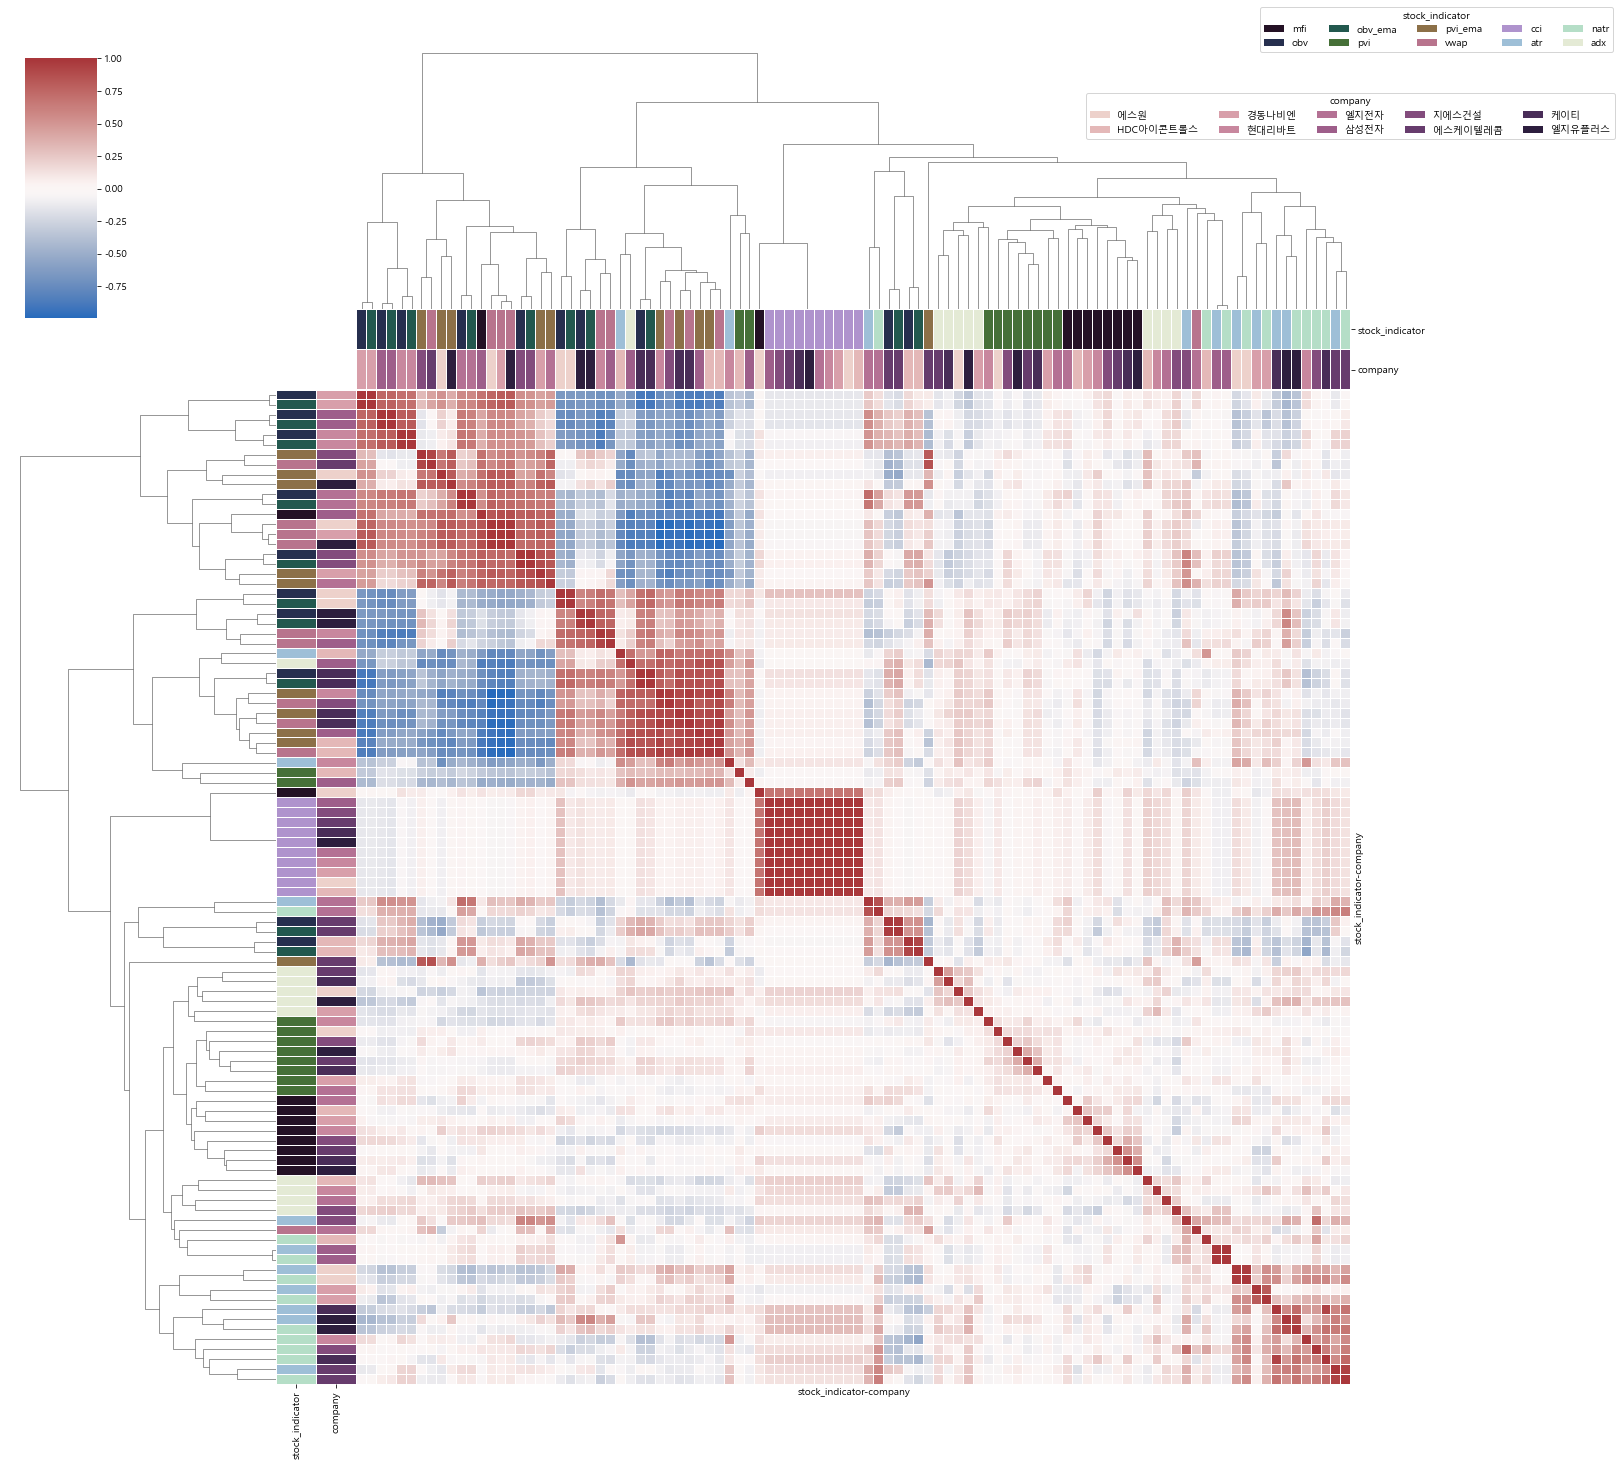

In [113]:
stock_company_colors = pd.DataFrame(stock_indicator_colors).join(pd.DataFrame(company_colors))
g = sns.clustermap(a.corr(),
                   row_cluster=True, col_cluster=True,
                   row_colors = stock_company_colors,
                   col_colors = stock_company_colors,
                   linewidths=0.01,
                   xticklabels=False, yticklabels=False,
                   center=0, cmap="vlag",
                   figsize=(20,20))

from matplotlib.pyplot import gcf
for label in labeling_by_stock_indicator.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut_by_stock_indicator[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='stock_indicator', loc="center", ncol=5, bbox_to_anchor=(1, 1), bbox_transform=gcf().transFigure)
for label in labeling_by_company.unique():
    g.ax_row_dendrogram.bar(0, 0, color=lut_by_company[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='company', loc="center", ncol=5, bbox_to_anchor=(0.94, 0.94), bbox_transform=gcf().transFigure)

plt.show()

<Figure size 432x288 with 0 Axes>

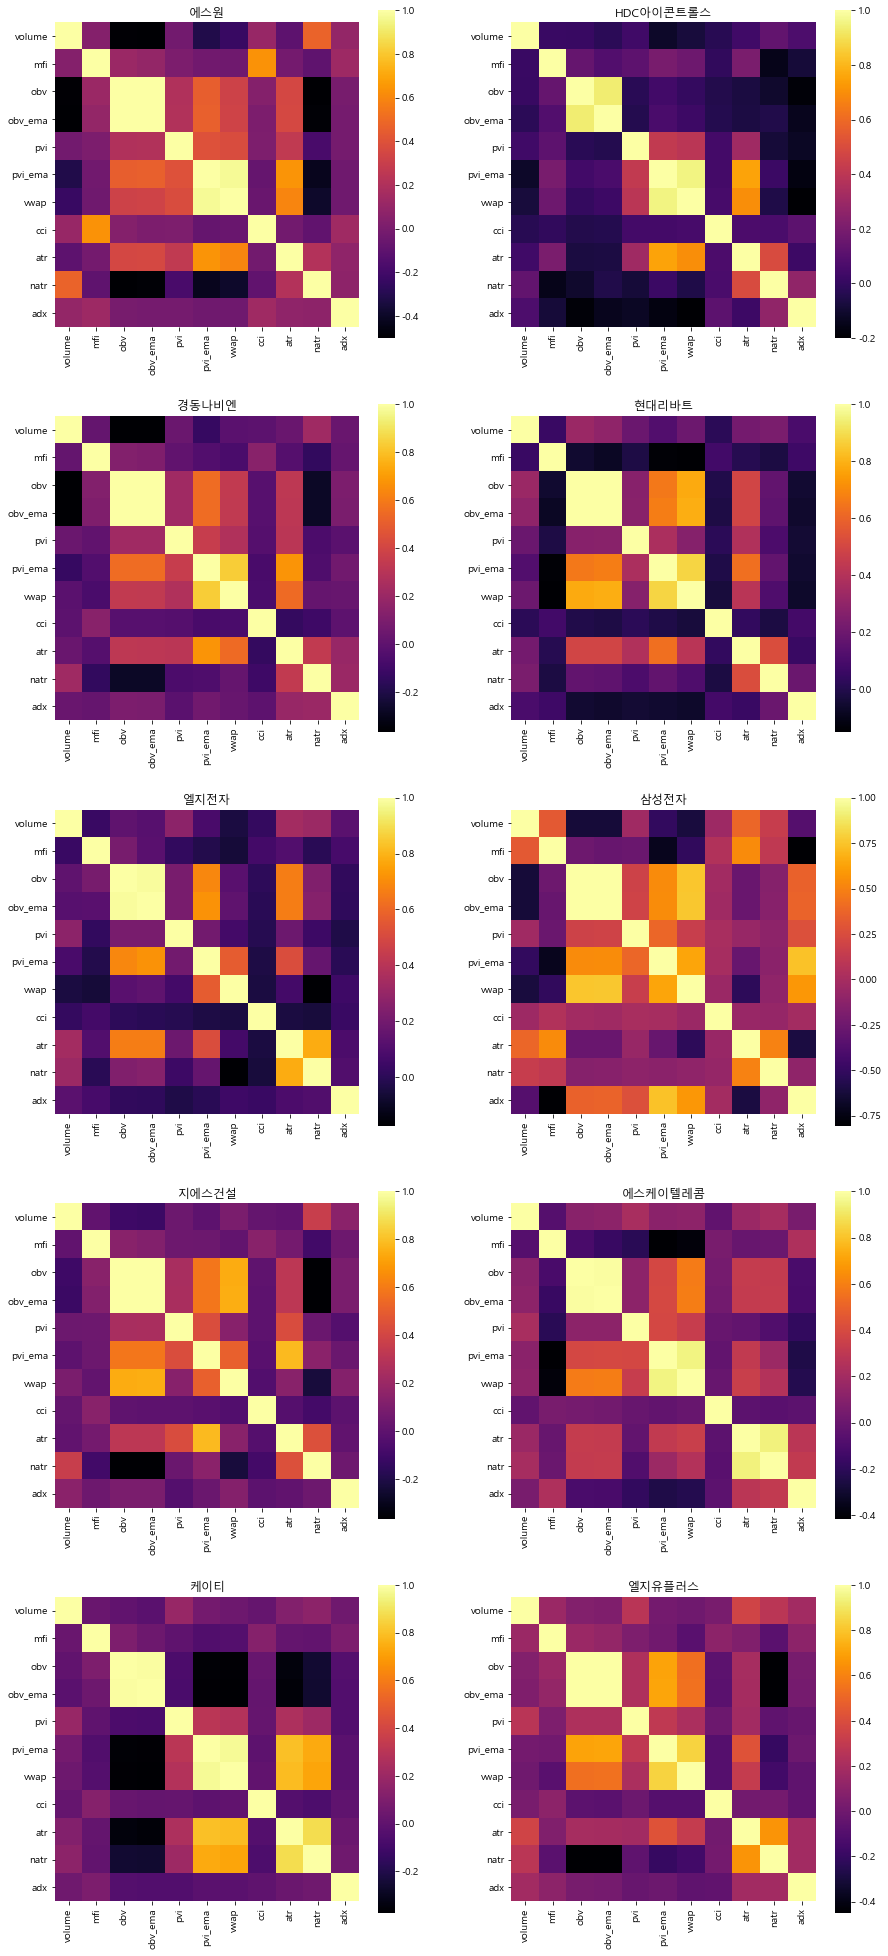

In [114]:
plt.figure()
fig, ax = plt.subplots(5, 2,figsize=(15, 35))

for i in range(10):
    ax =plt.subplot(5, 2,i+1)

    corr = Creating_technical_indicator[i].corr()
    sns.heatmap(corr, vmax=1, cmap="inferno", square=True) 
    
    ax.set_title(str(Sk_by_comp_n[i]['symbol'][0]))

plt.show()

***robust_scailing, and minmax scailing***

In [115]:
def robust_scale(df):
    scaler = preprocessing.RobustScaler() 
    scailed_df_robust = scaler.fit_transform(df)
    scailed_df_robust = pd.DataFrame(scailed_df_robust, columns=df.columns, index=df.index)
    return scailed_df_robust

def min_max_scale(df):
    scaler = preprocessing.MinMaxScaler() 
    scailed_df_minmax = scaler.fit_transform(df)
    scailed_df_minmax = pd.DataFrame(scailed_df_minmax, columns=df.columns, index=df.index)
    return scailed_df_minmax

def standard_scale(df):
    scaler = preprocessing.StandardScaler() 
    scailed_df_standar = scaler.fit_transform(df)
    scailed_df_standar = pd.DataFrame(scailed_df_standar, columns= df.columns, index=df.index)
    return scailed_df_standar


train_for_scaling = X_train.copy()
test_for_scaling = X_test.copy()

robust_tr_list = []
robust_te_list = []

minmax_tr_list = []
minmax_te_list = []

stndard_tr_list = []
stndard_te_list = []

for i in range(10):
    robust_tr_list.append(robust_scale(train_for_scaling[i]))
    robust_te_list.append(robust_scale(test_for_scaling[i]))
    
    minmax_tr_list.append(min_max_scale(robust_tr_list[i]))
    minmax_te_list.append(min_max_scale(robust_te_list[i]))
    
    stndard_tr_list.append(standard_scale(robust_tr_list[i]))
    stndard_te_list.append(standard_scale(robust_te_list[i]))    

<Figure size 432x288 with 0 Axes>

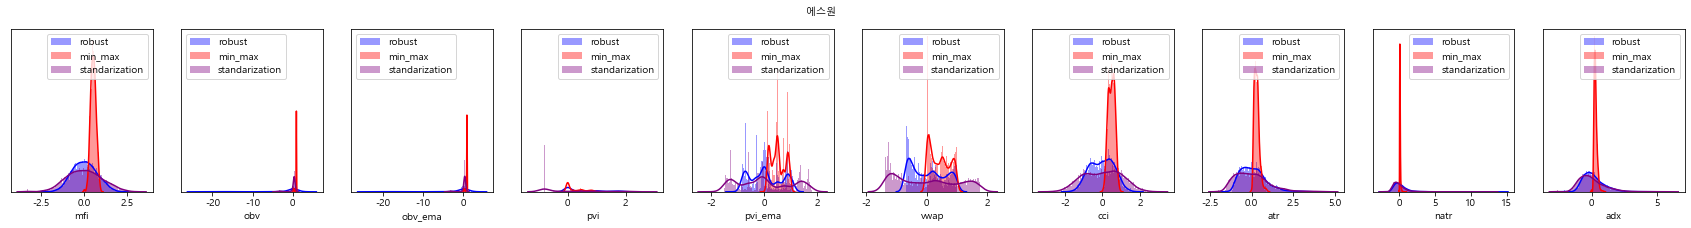

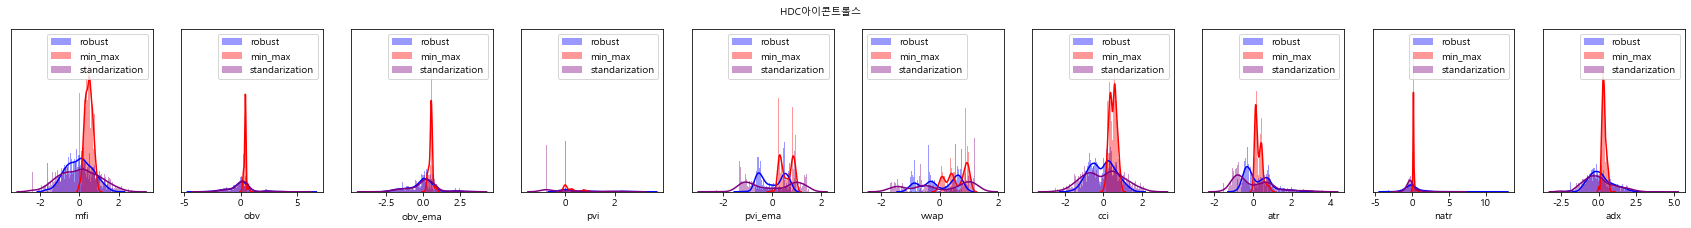

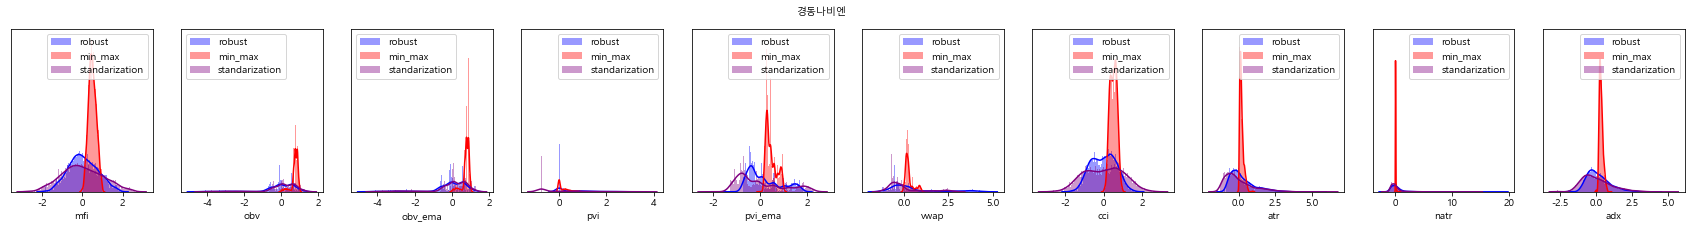

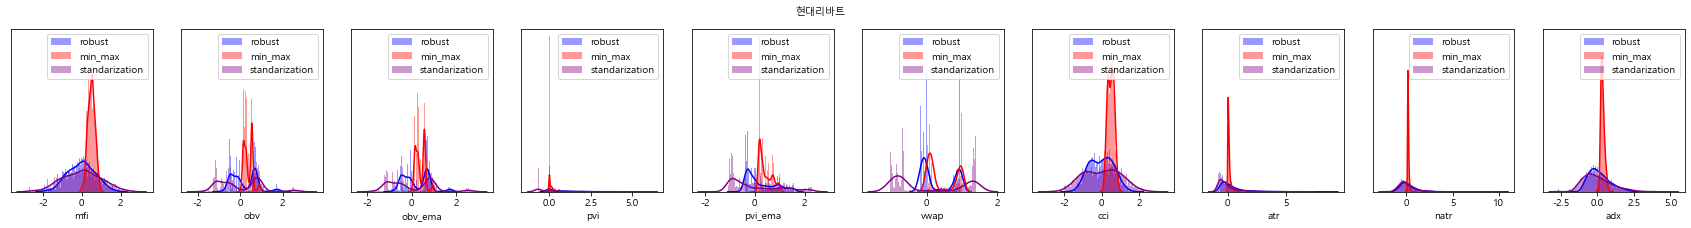

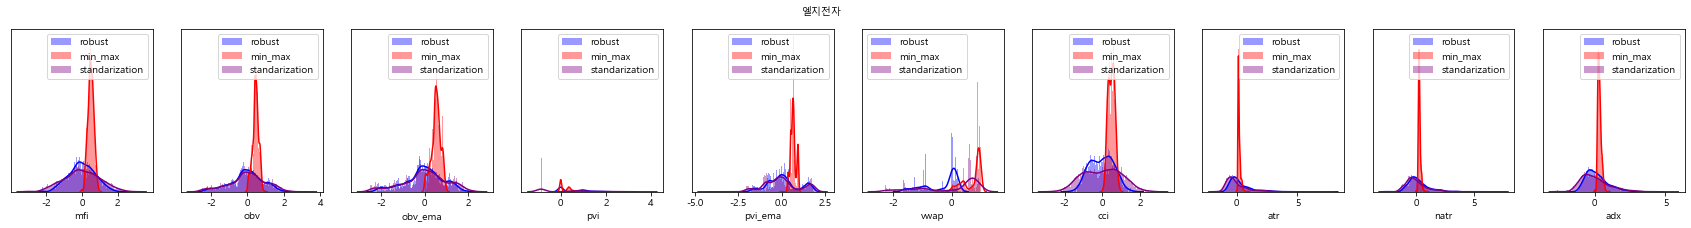

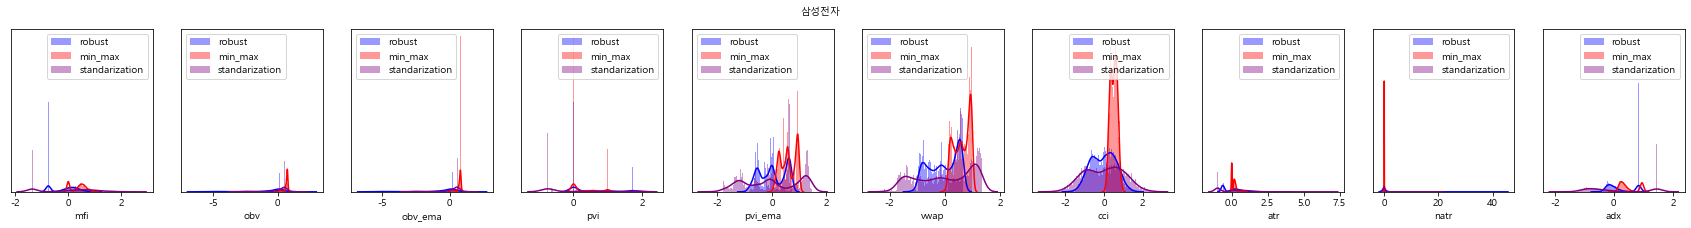

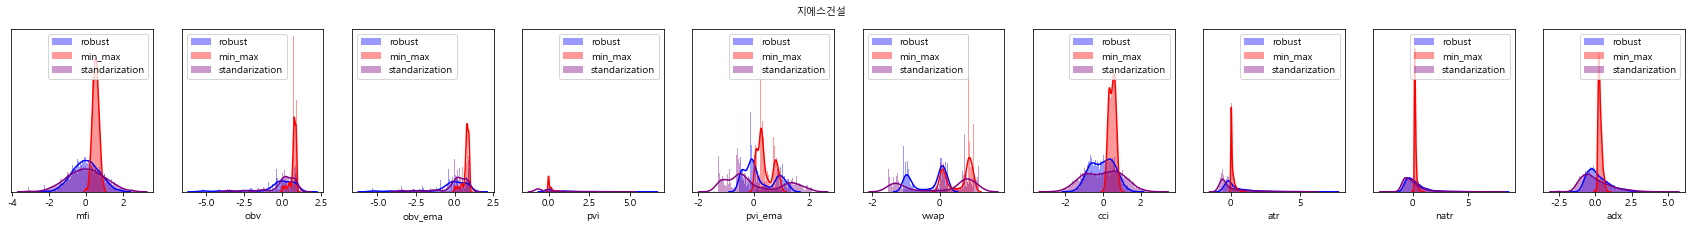

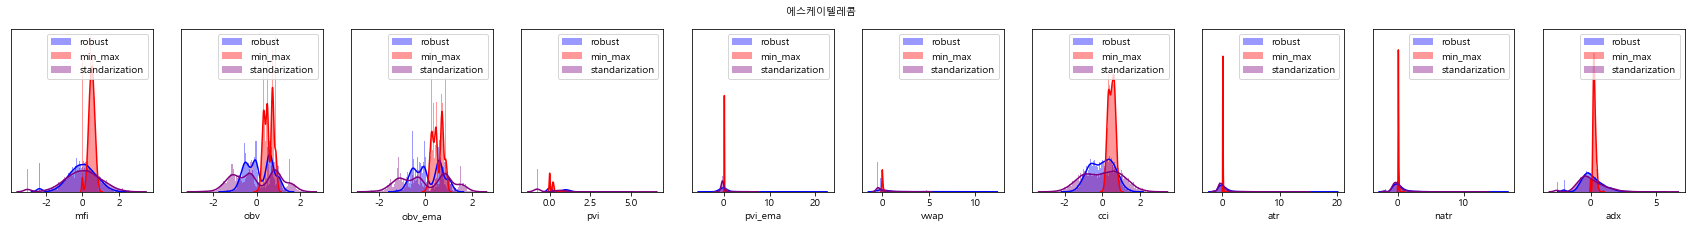

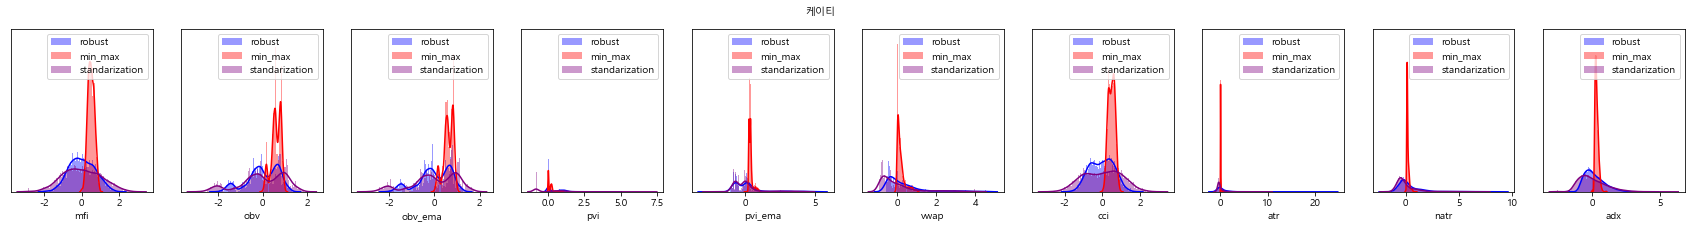

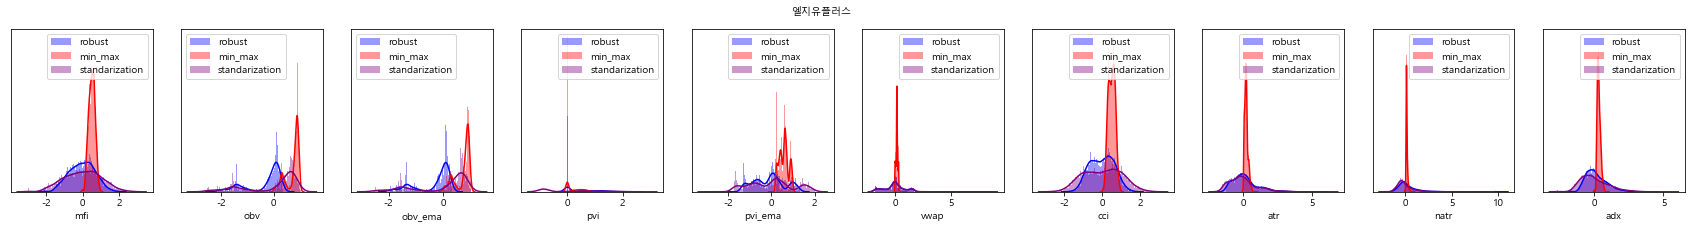

In [116]:
indicator_list = ['mfi', 'obv', 'obv_ema', 'pvi', 'pvi_ema', 'vwap', 'cci', 'atr', 'natr', 'adx']
plt.figure()
for j in range(10):
    fig, ax = plt.subplots(1,10,figsize=(30, 3))
    for feature in range(10):
        ax =plt.subplot(1, 10, (j-j + feature + 1))
        sns.distplot(robust_tr_list[j].iloc[:,feature], color="b", kde=True,bins=120, label='robust')
        sns.distplot(minmax_tr_list[j].iloc[:,feature], color="r", kde=True,bins=120, label='min_max')
        sns.distplot(stndard_tr_list[j].iloc[:,feature], color="purple", kde=True,bins=120, label='standarization')

        ax.set(xlabel=indicator_list[feature])
        ax.axes.yaxis.set_visible(False)
        plt.legend()
    plt.suptitle(Sk_by_comp_n[j]['symbol'][0],fontsize=10)
    plt.show()    

**Scaling 결과** 

In [136]:
import re
train_list_origin = X_train.copy()
train_list_scaled = stndard_tr_list.copy()

indicators = []

col_list = train_list[0].columns.tolist()

for i in col_list:
    text = re.sub('[^a-zA-Z0-9]',' ',i).strip()
    if(text != ''):
        indicators.append(text)

for j in range(len(train_list_origin)):
    train_list_origin[j].columns = indicators[0:10]
    train_list_scaled[j].columns = indicators[0:10]
    
non_scaled = pd.concat(train_list_origin)
scaled = pd.concat(train_list_scaled)

In [206]:
fig = make_subplots(rows=1, cols=2,
                   subplot_titles=("Non-scaled", "Scaled"))

for col in non_scaled:
  fig.add_trace(go.Box(y=non_scaled[col].values, name=non_scaled[col].name),row=1, col=1)
  fig.add_trace(go.Box(y=scaled[col].values, name=scaled[col].name),row=1, col=2)

fig.update_layout(height=600, 
                  width=900,
                  plot_bgcolor='lightcyan',
                  showlegend=False,
                  title_text="Comparison of results before and after scaling")
iplot(fig)

**Try to estimation with the model called xgboost**

    - below is version of test

In [64]:
trial = {'lambda': 0.0030282073258141168, 'alpha': 0.01563845128469084, 'colsample_bytree': 0.5,
         'subsample': 0.7,'n_estimators': 4000, 'learning_rate': 0.01,'max_depth': 15,
         'random_state': 2020, 'min_child_weight': 257}

In [65]:
def traial_xgboost(nth):
    stndard_tr_list[nth].columns = stndard_te_list[nth].columns
    features = stndard_tr_list[nth].columns.tolist()
    
    train = stndard_tr_list[nth].copy()
    test = stndard_te_list[nth].copy()
    target = y_train[nth].copy()

    preds = np.zeros(test.shape[0])

    kf = KFold(n_splits=7,random_state=48, shuffle=True)
    rmse=[]
    n=0

    for trn_idx, test_idx in kf.split(train[features],target):
        X_tr,X_val=train[features].iloc[trn_idx],train[features].iloc[test_idx]
        y_tr,y_val=target.iloc[trn_idx],target.iloc[test_idx]

        model = xgb.XGBRegressor(**trial)
        model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)

        preds+=model.predict(test[features])/kf.n_splits
        rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
        print(n+1,rmse[n])
        n+=1
    print(f"mean RMSE for all the folds is {np.mean(rmse)}")

In [66]:
def fitting_Best_parms(nth):
    Best_parms = study.best_params

    stndard_tr_list[nth].columns = stndard_te_list[nth].columns
    features = stndard_tr_list[nth].columns.tolist()
    stndard_tr_list[nth].columns
    train = stndard_tr_list[nth].copy()
    test = stndard_te_list[nth].copy()

    target = y_train[nth].copy()

    preds = np.zeros(test.shape[0])

    kf = KFold(n_splits=7,random_state=48, shuffle=True)
    rmse=[]
    n=0

    for trn_idx, test_idx in kf.split(train[features],target):
        X_tr,X_val=train[features].iloc[trn_idx],train[features].iloc[test_idx]
        y_tr,y_val=target.iloc[trn_idx],target.iloc[test_idx]

        model = xgb.XGBRegressor(**Best_parms)
        model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)

        preds+=model.predict(test[features])/kf.n_splits
        rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
        print(n+1,rmse[n])
        n+=1
    print(f"mean RMSE for all the folds is {np.mean(rmse)}")
    print('='*50, stock_name_list[nth], 'Result after optimisation') 

**The line below illustrates the code of xgboost based on 10 companies that have been selcted for stock index with the volume relations.**

In [67]:
for nth in range(10):
    
    traial_xgboost(nth)
    
    train_x = stndard_tr_list[nth].copy()
    test_x = stndard_te_list[nth].copy()
    train_y= y_train[nth].copy()
    test_y= y_test[nth].copy()

    def objective(trial):
        param = {
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
            'n_estimators': 4000,
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
            'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        model = xgb.XGBRegressor(**param)  
        model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
        preds = model.predict(test_x)
        rmse = mean_squared_error(test_y, preds,squared=False)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    print('='*50, stock_name_list[nth], 'Result before optimisation')
    
    fitting_Best_parms(nth)

1 61865.72250779223
2 67935.25694944046
3 89281.26695765645
4 68016.55101743035
5 82577.73135944289
6 76846.94871105914
7 81382.51712005332
mean RMSE for all the folds is 75415.14208898212


[I 2021-03-25 13:06:13,578] Finished trial#0 resulted in value: 82244.39712565295. Current best value is 82244.39712565295 with parameters: {'lambda': 1.7088479621480759, 'alpha': 0.004185135229415211, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 283}.
[I 2021-03-25 13:06:24,328] Finished trial#1 resulted in value: 88215.45041870409. Current best value is 82244.39712565295 with parameters: {'lambda': 1.7088479621480759, 'alpha': 0.004185135229415211, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 283}.
[I 2021-03-25 13:06:40,648] Finished trial#2 resulted in value: 82386.02066213734. Current best value is 82244.39712565295 with parameters: {'lambda': 1.7088479621480759, 'alpha': 0.004185135229415211, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 283}.
[I 2021

Number of finished trials: 50
Best trial: {'lambda': 0.2893846641806886, 'alpha': 8.0633765512561, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 4}
================================================== 에스원 Result before optimisation
1 81017.52863716608
2 80437.50725332412
3 113406.37504804228
4 95135.35437360073
5 104906.48570031459
6 91743.73915524362
7 97649.97836542278
mean RMSE for all the folds is 94899.56693330202
================================================== 에스원 Result after optimisation
1 313045.96377948637
2 75640.61115310411
3 467501.5088659241
4 197704.10570537363
5 157436.68626836516
6 115408.52609392199
7 237297.02171556474
mean RMSE for all the folds is 223433.48908310573


[I 2021-03-25 13:15:24,804] Finished trial#0 resulted in value: 82128.25168661546. Current best value is 82128.25168661546 with parameters: {'lambda': 0.02216951778573345, 'alpha': 0.11439939420248832, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 1}.
[I 2021-03-25 13:15:25,206] Finished trial#1 resulted in value: 76263.26337554745. Current best value is 76263.26337554745 with parameters: {'lambda': 0.06194489135753574, 'alpha': 0.0012715284499630018, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 185}.
[I 2021-03-25 13:15:25,834] Finished trial#2 resulted in value: 76348.48401620316. Current best value is 76263.26337554745 with parameters: {'lambda': 0.06194489135753574, 'alpha': 0.0012715284499630018, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 185}.
[I

Number of finished trials: 50
Best trial: {'lambda': 0.2175213881174323, 'alpha': 0.0686723879387887, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 247}
================================================== HDC아이콘트롤스 Result before optimisation
1 315588.0907953539
2 73828.31678919298
3 481881.6591401415
4 217110.69959305893
5 164074.14805662454
6 122715.50254278054
7 240699.88967911573
mean RMSE for all the folds is 230842.61522803828
================================================== HDC아이콘트롤스 Result after optimisation
1 87627.64184233938
2 149537.41886852856
3 98009.97379429567
4 78197.39784070179
5 99901.36716494735
6 129719.98202196891
7 82964.91257239293
mean RMSE for all the folds is 103708.38487216781


[I 2021-03-25 13:17:27,611] Finished trial#0 resulted in value: 215018.11731738405. Current best value is 215018.11731738405 with parameters: {'lambda': 0.060058723879140984, 'alpha': 0.10629060814342631, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 141}.
[I 2021-03-25 13:17:44,835] Finished trial#1 resulted in value: 205190.9821406195. Current best value is 205190.9821406195 with parameters: {'lambda': 0.00794634006113061, 'alpha': 0.0015597931225146868, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 146}.
[I 2021-03-25 13:17:57,356] Finished trial#2 resulted in value: 215564.27845789536. Current best value is 205190.9821406195 with parameters: {'lambda': 0.00794634006113061, 'alpha': 0.0015597931225146868, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 

Number of finished trials: 50
Best trial: {'lambda': 4.296227316675594, 'alpha': 0.20910046860758244, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 5}
================================================== 경동나비엔 Result before optimisation
1 88717.0451638239
2 158600.28176277658
3 103857.0798860214
4 86179.90355618378
5 106926.32442269621
6 130084.17816118793
7 92745.95163671472
mean RMSE for all the folds is 109587.25208420065
================================================== 경동나비엔 Result after optimisation
1 75401.73769064291
2 138518.14723732465
3 97829.03493638932
4 161759.42954158376
5 228191.99636918216
6 100481.0136099043
7 216933.52933190184
mean RMSE for all the folds is 145587.84124527554


[I 2021-03-25 13:29:19,436] Finished trial#0 resulted in value: 145879.88235782867. Current best value is 145879.88235782867 with parameters: {'lambda': 0.005693520682870649, 'alpha': 1.2003884425966023, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 71}.
[I 2021-03-25 13:29:22,816] Finished trial#1 resulted in value: 129777.83984697067. Current best value is 129777.83984697067 with parameters: {'lambda': 3.997560511374557, 'alpha': 0.2534506045633877, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 3}.
[I 2021-03-25 13:29:26,052] Finished trial#2 resulted in value: 152633.00119176702. Current best value is 129777.83984697067 with parameters: {'lambda': 3.997560511374557, 'alpha': 0.2534506045633877, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 3}.
[I 2021-0

Number of finished trials: 50
Best trial: {'lambda': 3.997560511374557, 'alpha': 0.2534506045633877, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 3}
================================================== 현대리바트 Result before optimisation
1 89389.3463223876
2 147368.1283834967
3 101565.22641379798
4 176921.18785267108
5 252604.282602293
6 98057.58724470642
7 241509.65049607307
mean RMSE for all the folds is 158202.20133077513
================================================== 현대리바트 Result after optimisation
1 689016.0275627587
2 477820.68262119417
3 506638.37490527245
4 765964.7979544068
5 812986.0432448144
6 499990.8918079068
7 455498.12815094314
mean RMSE for all the folds is 601130.7066067567


[I 2021-03-25 13:33:41,528] Finished trial#0 resulted in value: 954988.861719205. Current best value is 954988.861719205 with parameters: {'lambda': 0.006409624571344149, 'alpha': 0.1626432288741458, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 20}.
[I 2021-03-25 13:33:51,722] Finished trial#1 resulted in value: 914671.4392455444. Current best value is 914671.4392455444 with parameters: {'lambda': 0.031294106055578176, 'alpha': 0.0012549968098176615, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 192}.
[I 2021-03-25 13:34:18,007] Finished trial#2 resulted in value: 943536.6353169498. Current best value is 914671.4392455444 with parameters: {'lambda': 0.031294106055578176, 'alpha': 0.0012549968098176615, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 192}.
[I 2

Number of finished trials: 50
Best trial: {'lambda': 0.3200245483369569, 'alpha': 0.027820729990572144, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 238}
================================================== 엘지전자 Result before optimisation
1 774449.6198772818
2 514192.1376636439
3 552844.650344297
4 872567.6753951136
5 921884.9673888434
6 562875.3601222782
7 483864.2849474713
mean RMSE for all the folds is 668954.0993912758
================================================== 엘지전자 Result after optimisation
1 9202398.265327096
2 8807356.511376612


KeyboardInterrupt: 